In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/IoT/data-science-bowl-2018.zip

Archive:  /content/drive/MyDrive/IoT/data-science-bowl-2018.zip


In [ ]:
!mkdir -p /content/train
!unzip /content/stage1_train.zip -d /content/train

unzip:  cannot find or open /content/stage1_train.zip, /content/stage1_train.zip.zip or /content/stage1_train.zip.ZIP.


In [ ]:
!pip install stardist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install "numpy<2" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 64.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have nu

In [ ]:
import numpy as np
print(np.__version__)   # phải là 1.26.x
import stardist
stardist.__version__

1.26.4


'0.9.1'

In [ ]:
ROOT = "content/train"

In [ ]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm

import imageio.v2 as imageio
from csbdeep.utils import normalize

ROOT = "/content/train"

X, Y = [], []

subfolders = sorted(glob(ROOT + "/*/"))

print("Found", len(subfolders), "subfolders")

for sub in subfolders:
    img_path = glob(os.path.join(sub, "images", "*.png"))[0]
    mask_paths = sorted(glob(os.path.join(sub, "masks", "*.png")))

    # -------- LOAD IMAGE --------
    img_raw = imageio.imread(img_path)

    if img_raw.ndim == 3:
        img_raw = np.mean(img_raw[..., :3], axis=-1)

    img = normalize(img_raw, 1, 99.8)

    # -------- BUILD INSTANCE MASK --------
    h, w = img.shape
    inst_mask = np.zeros((h, w), dtype=np.int32)

    obj_id = 1
    for mp in mask_paths:
        m = imageio.imread(mp)
        if m.ndim == 3:
            m = m[..., 0]

        m = (m > 0).astype(np.uint8)
        inst_mask[m == 1] = obj_id
        obj_id += 1

    X.append(img)
    Y.append(inst_mask)


print("Loaded", len(X), "images")
print("Example:", X[0].shape, Y[0].shape)



Found 0 subfolders
Loaded 0 images


IndexError: list index out of range

In [ ]:
import numpy as np
import random
import cv2  # nếu chưa có thì !pip install opencv-python-headless

def augmenter(x, y):
    assert x.shape[:2] == y.shape[:2]

    # ----- Flip ngang -----
    if random.random() < 0.5:
        x = np.flip(x, axis=1)
        y = np.flip(y, axis=1)

    # ----- Flip dọc -----
    if random.random() < 0.5:
        x = np.flip(x, axis=0)
        y = np.flip(y, axis=0)

    # ----- Rotate 0/90/180/270 -----
    k = random.randint(0, 3)
    x = np.rot90(x, k)
    y = np.rot90(y, k)

    # ----- Zoom nhẹ (crop + resize) -----
    if random.random() < 0.5:
        h, w = x.shape[:2]
        scale = random.uniform(0.85, 1.0)
        nh, nw = int(h * scale), int(w * scale)
        top  = random.randint(0, h - nh)
        left = random.randint(0, w - nw)

        x_crop = x[top:top+nh, left:left+nw]
        y_crop = y[top:top+nh, left:left+nw]

        x = cv2.resize(x_crop, (w, h), interpolation=cv2.INTER_LINEAR)
        y = cv2.resize(y_crop, (w, h), interpolation=cv2.INTER_NEAREST).astype(np.int32)

    # ----- Gamma / độ tương phản -----
    if random.random() < 0.5:
        gamma = random.uniform(0.8, 1.2)
        x = x.astype(np.float32)
        x = x - x.min()
        if x.max() > 0:
            x = x / x.max()
        x = np.power(x, gamma)

    # ----- Gaussian noise -----
    if random.random() < 0.5:
        noise_std = random.uniform(0.0, 0.05)
        noise = np.random.normal(0, noise_std, size=x.shape).astype(np.float32)
        x = x.astype(np.float32) + noise
        x = np.clip(x, 0.0, 1.0)

    return x.astype('float32'), y

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)

from stardist.models import Config2D, StarDist2D


config = Config2D(
    n_rays=64,
    grid=(2,2),
    train_patch_size=(256,256),

    # tăng độ sâu + số filter của U-Net
    unet_n_depth=4,           # mặc định 3 → sâu hơn, học được pattern phức tạp hơn
    unet_n_filter_base=64,    # mặc định 32 → nhiều kênh feature hơn

    # training hyperparams
    train_batch_size=4,       # nếu GPU đủ, có thể tăng lên 8
    train_learning_rate=2e-4  # nhỏ hơn mặc định 3e-4 → học “mượt” hơn

)

model = StarDist2D(config=config, name="stardist_model", basedir="models")

history = model.train(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=250,
    steps_per_epoch=250,
    augmenter=augmenter
)





base_model.py (203): output path for model already exists, files may be overwritten: /content/models/stardist_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 243ms/step - dist_dist_iou_metric: 0.1350 - dist_loss: 11.4985 - dist_relevant_mae: 11.4980 - dist_relevant_mse: 256.1326 - loss: 2.7046 - prob_kld: 0.3235 - prob_loss: 0.4049 - val_dist_dist_iou_metric: 0.3053 - val_dist_loss: 6.4584 - val_dist_relevant_mae: 6.3917 - val_dist_relevant_mse: 97.1965 - val_loss: 1.4906 - val_prob_kld: 0.1443 - val_prob_loss: 0.2138 - learning_rate: 2.0000e-04
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - dist_dist_iou_metric: 0.3371 - dist_loss: 7.1418 - dist_relevant_mae: 7.1404 - dist_relevant_mse: 110.4821 - loss: 1.6514 - prob_kld: 0.1426 - prob_loss: 0.2231 - val_dist_dist_iou_metric: 0.4409 - val_dist_loss: 5.3752 - val_dist_relevant_mae: 5.3477 - val_dist_relevant_mse: 62.7158 - val_loss: 1.2287 - val_prob_kld: 0.0898 - val_prob_loss: 0.1592 - learning_rate: 2.0000e-04
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - dist_dist_i

<> (21): invalid escape sequence '\_'
<> (21): invalid escape sequence '\_'
ipython-input-893348904.py (21): invalid escape sequence '\_'


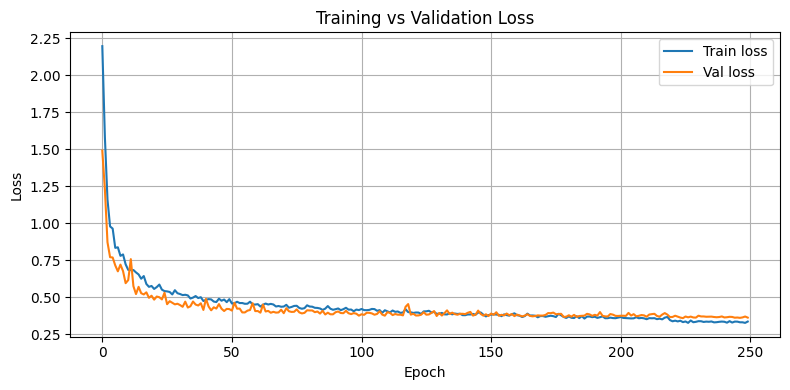

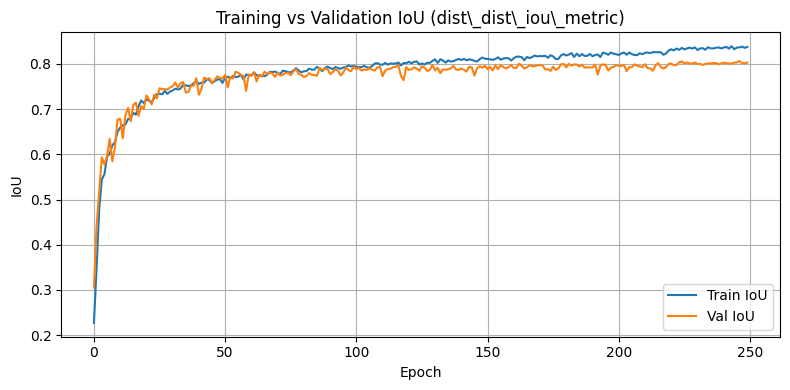

In [ ]:
import matplotlib.pyplot as plt

# ----- 1. Loss vs Val Loss -----
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- 2. "Accuracy": dist_dist_iou_metric vs val_dist_dist_iou_metric -----
plt.figure(figsize=(8,4))
plt.plot(history.history['dist_dist_iou_metric'], label='Train IoU')
plt.plot(history.history['val_dist_dist_iou_metric'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training vs Validation IoU (dist\_dist\_iou\_metric)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- model thường (nray = 32, grd = 2,2)

100 epochs, acc =0.836, valacc = 0,776, fram0027 = 104,

200 epochs, acc =0.8684, valacc = 0,7629, fram0027 = 104,

- model thường (nray = 64, grd = 2,2)

100 epochs, acc =0.8379, valacc = 0,7654, fram0027 = 104, frame0003 = 85

150 epochs, acc =0.8564, valacc = 0,7621, fram0027 = 104, frame0003 = 85

200 epochs, acc =0.8714, valacc = 0,7696, fram0027 = 104, frame0003 = 85

reduceLR, earlystopping, ...
250 epochs, acc =0.8351, valacc = 0,8029, fram0027 = 104, frame0003 = 85

In [ ]:
!mv /content/models /content/drive/MyDrive/IoT/

mv: cannot stat '/content/models': No such file or directory


In [ ]:
from stardist.models import StarDist2D

model = StarDist2D(
    config=None,
    name="stardist_model",
    basedir="/content/drive/MyDrive/IoT/models"
)

print("Model loaded ✓")



Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Model loaded ✓


In [ ]:
!unzip /content/drive/MyDrive/IoT/BubbleImages_.zip

Archive:  /content/drive/MyDrive/IoT/BubbleImages_.zip
   creating: frames/
  inflating: frames/frame_0001.png   
  inflating: frames/frame_0002.png   
  inflating: frames/frame_0003.png   
  inflating: frames/frame_0004.png   
  inflating: frames/frame_0005.png   
  inflating: frames/frame_0006.png   
  inflating: frames/frame_0007.png   
  inflating: frames/frame_0008.png   
  inflating: frames/frame_0009.png   
  inflating: frames/frame_0010.png   
  inflating: frames/frame_0011.png   
  inflating: frames/frame_0012.png   
  inflating: frames/frame_0013.png   
  inflating: frames/frame_0014.png   
  inflating: frames/frame_0015.png   
  inflating: frames/frame_0016.png   
  inflating: frames/frame_0017.png   
  inflating: frames/frame_0018.png   
  inflating: frames/frame_0019.png   
  inflating: frames/frame_0020.png   
  inflating: frames/frame_0021.png   
  inflating: frames/frame_0022.png   
  inflating: frames/frame_0023.png   
  inflating: frames/frame_0024.png   
  inflating:

Số bubble dự đoán: 85


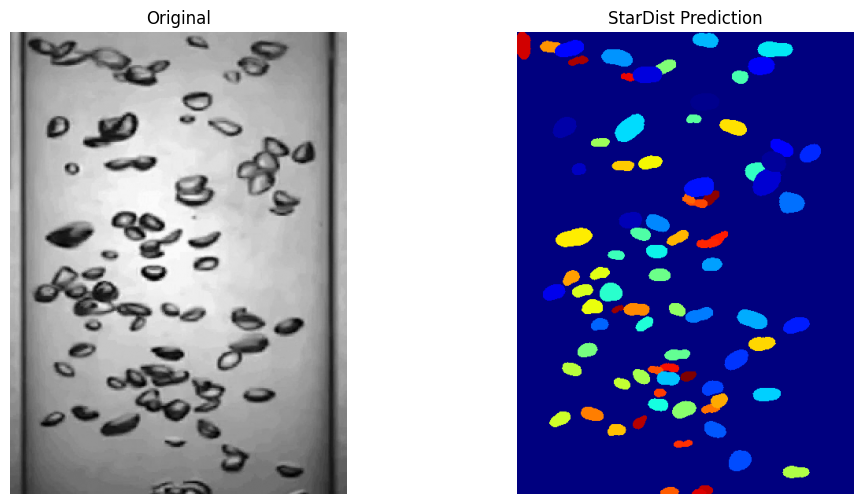

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0003.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán:", labels.max())

# ----- VẼ KẾT QUẢ -----
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("StarDist Prediction")
plt.imshow(labels, cmap="jet")
plt.axis("off")

plt.show()


Số bubble dự đoán (labels.max): 85

=== Thông tin từng bubble ===
Bubble 1: area = 659.0 pixel, centroid = (238.1, 88.5)
Bubble 2: area = 655.0 pixel, centroid = (325.7, 164.7)
Bubble 3: area = 602.0 pixel, centroid = (60.0, 120.9)
Bubble 4: area = 506.0 pixel, centroid = (143.9, 239.2)
Bubble 5: area = 223.0 pixel, centroid = (78.2, 174.2)
Bubble 6: area = 897.0 pixel, centroid = (316.2, 191.1)
Bubble 7: area = 666.0 pixel, centroid = (165.2, 53.9)
Bubble 8: area = 457.0 pixel, centroid = (46.5, 330.9)
Bubble 9: area = 633.0 pixel, centroid = (309.9, 42.7)
Bubble 10: area = 461.0 pixel, centroid = (336.1, 146.7)
Bubble 11: area = 601.0 pixel, centroid = (66.5, 21.0)
Bubble 12: area = 763.0 pixel, centroid = (231.4, 197.2)
Bubble 13: area = 530.0 pixel, centroid = (354.3, 372.9)
Bubble 14: area = 479.0 pixel, centroid = (372.1, 154.0)
Bubble 15: area = 568.0 pixel, centroid = (278.2, 416.7)
Bubble 16: area = 406.0 pixel, centroid = (247.8, 452.6)
Bubble 17: area = 612.0 pixel, centroid

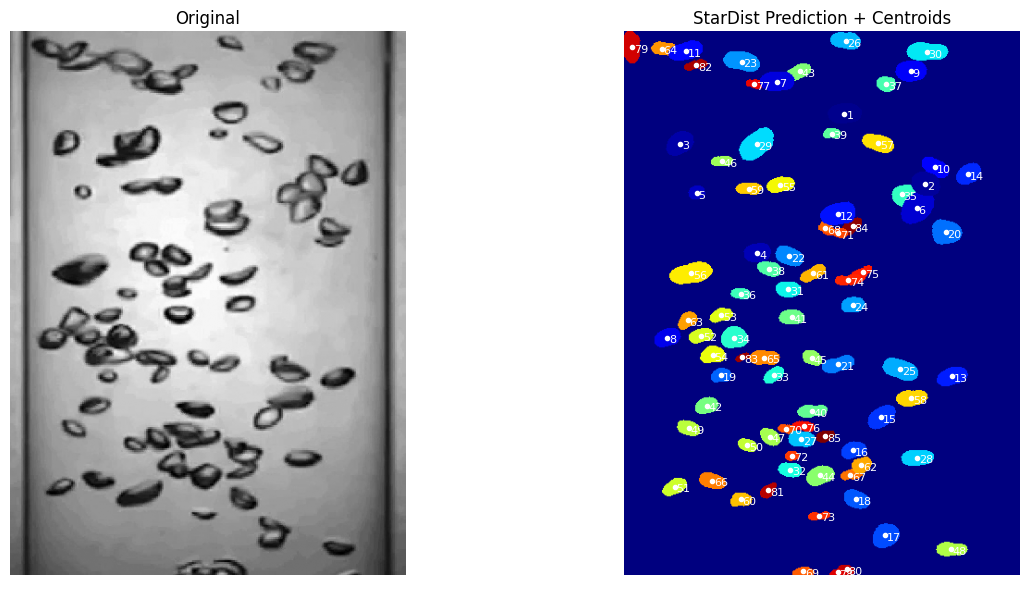

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize
from skimage.measure import regionprops  # 👈 THÊM IMPORT NÀY

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0003.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán (labels.max):", labels.max())

# ----- PHÂN TÍCH TỪNG BUBBLE -----
regions = regionprops(labels)  # tự bỏ background (label = 0)

areas = []
print("\n=== Thông tin từng bubble ===")
for i, r in enumerate(regions, start=1):
    area = r.area                     # diện tích theo số pixel
    cy, cx = r.centroid               # (row, col) = (y, x)
    areas.append(area)
    print(f"Bubble {i}: area = {area} pixel, centroid = ({cx:.1f}, {cy:.1f})")

total_area = np.sum(areas)
print("\nTổng số bubble (regionprops):", len(regions))
print("Tổng diện tích tất cả bubble:", total_area, "pixel")

# ----- VẼ KẾT QUẢ + MINH HỌA TRỰC QUAN -----
plt.figure(figsize=(14, 6))

# Ảnh gốc
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

# Ảnh nhãn + centroid + ID
plt.subplot(1, 2, 2)
plt.title("StarDist Prediction + Centroids")
plt.imshow(labels, cmap="jet")
plt.axis("off")

for i, r in enumerate(regions, start=1):
    cy, cx = r.centroid
    # chấm centroid
    plt.plot(cx, cy, 'wo', markersize=3)
    # in ID cạnh centroid
    plt.text(cx + 2, cy + 2, str(i),
             color='white', fontsize=8, ha='left', va='center')

plt.tight_layout()
plt.show()


Số bubble dự đoán: 104


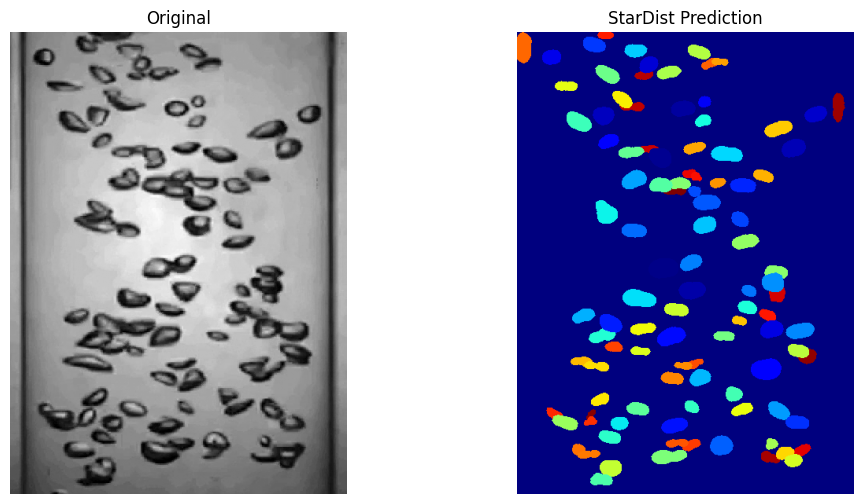

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0027.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán:", labels.max())

# ----- VẼ KẾT QUẢ -----
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("StarDist Prediction")
plt.imshow(labels, cmap="jet")
plt.axis("off")

plt.show()


Số bubble dự đoán: 105


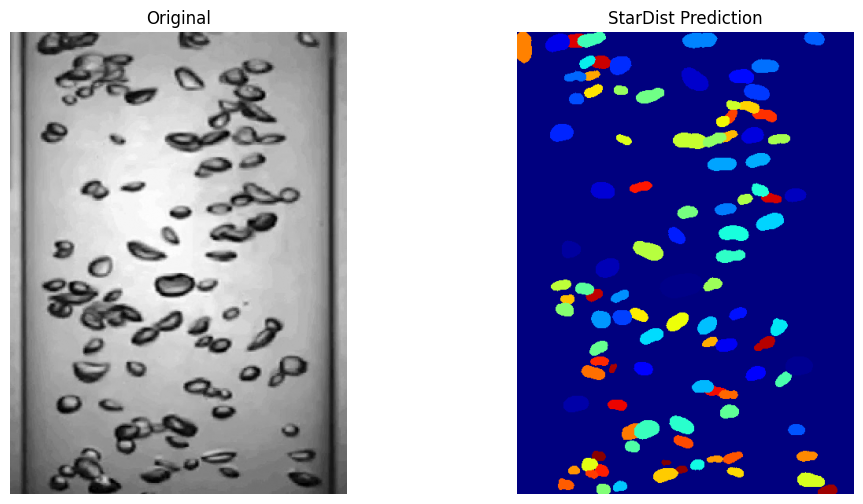

In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize

# ----- LOAD IMAGE -----
img = imageio.imread("/content/frames/frame_0128.png")

# Nếu ảnh RGBA hoặc RGB → chuyển grayscale
if img.ndim == 3:
    img = img[..., :3]
    img = np.mean(img, axis=-1)

img_n = normalize(img, 1, 99.8)

# ----- PREDICT -----
labels, _ = model.predict_instances(img_n)

print("Số bubble dự đoán:", labels.max())

# ----- VẼ KẾT QUẢ -----
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("StarDist Prediction")
plt.imshow(labels, cmap="jet")
plt.axis("off")

plt.show()


In [ ]:
import os
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.utils import normalize
from skimage.measure import regionprops

# ============================
#   THƯ MỤC INPUT / OUTPUT
# ============================
FRAME_DIR   = "/content/frames"
MASK_DIR    = "/content/output_masks"      # ảnh mask trắng/đen
LABELED_DIR = "/content/output_labeled"    # ảnh có số label + centroid
TXT_PATH    = "/content/bubble_areas.txt"  # file text lưu diện tích

os.makedirs(MASK_DIR, exist_ok=True)
os.makedirs(LABELED_DIR, exist_ok=True)

# ============================
#   MỞ FILE TEXT GHI KẾT QUẢ
# ============================
f = open(TXT_PATH, "w", encoding="utf-8")
f.write("filename,bubble_id,area_px,centroid_x,centroid_y\n")

# ============================
#   DUYỆT TOÀN BỘ ẢNH
# ============================
image_names = sorted([
    fn for fn in os.listdir(FRAME_DIR)
    if fn.lower().endswith((".png", ".jpg", ".jpeg"))
])

print("Found", len(image_names), "images")

for fname in image_names:
    path = os.path.join(FRAME_DIR, fname)

    # ----- LOAD IMAGE -----
    img = imageio.imread(path)

    # RGB → Grayscale nếu cần
    if img.ndim == 3:
        img = img[..., :3]
        img = np.mean(img, axis=-1)

    img_n = normalize(img, 1, 99.8)

    # ----- PREDICT -----
    labels, _ = model.predict_instances(img_n)
    print(f"{fname}: dự đoán {labels.max()} bubbles")

    # ============================
    # 1) LƯU ẢNH MASK (CHỈ BUBBLE)
    # ============================
    # mask nhị phân: 0 = nền, 255 = bubble
    mask_binary = (labels > 0).astype(np.uint8) * 255

    mask_name = os.path.splitext(fname)[0] + "_mask.png"
    mask_path = os.path.join(MASK_DIR, mask_name)
    imageio.imwrite(mask_path, mask_binary)

    # ============================
    # 2) TÍNH REGIONPROPS & GHI TEXT
    # ============================
    regions = regionprops(labels)

    # ============================
    # 3) VẼ ẢNH LABEL + CENTROID + ID
    # ============================
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.imshow(labels, cmap="jet")
    ax.axis("off")
    ax.set_title(f"{fname} - {len(regions)} bubbles")

    for i, r in enumerate(regions, start=1):
        area = r.area
        cy, cx = r.centroid  # (row, col) = (y, x)

        # ghi vào file text
        f.write(f"{fname},{i},{area},{cx:.2f},{cy:.2f}\n")

        # vẽ centroid + ID
        ax.plot(cx, cy, 'wo', markersize=3)
        ax.text(cx + 2, cy + 2, str(i),
                color='white', fontsize=8,
                ha='left', va='center')

    labeled_name = os.path.splitext(fname)[0] + "_labeled.png"
    labeled_path = os.path.join(LABELED_DIR, labeled_name)

    fig.savefig(labeled_path, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.close(fig)

# đóng file text
f.close()

print("\nĐã lưu:")
print(" - Ảnh mask  :", MASK_DIR)
print(" - Ảnh labeled:", LABELED_DIR)
print(" - File text  :", TXT_PATH)


Found 886 images
frame_0001.png: dự đoán 80 bubbles
frame_0002.png: dự đoán 80 bubbles
frame_0003.png: dự đoán 85 bubbles
frame_0004.png: dự đoán 85 bubbles
frame_0005.png: dự đoán 92 bubbles
frame_0006.png: dự đoán 84 bubbles
frame_0007.png: dự đoán 93 bubbles
frame_0008.png: dự đoán 89 bubbles
frame_0009.png: dự đoán 88 bubbles
frame_0010.png: dự đoán 98 bubbles
frame_0011.png: dự đoán 98 bubbles
frame_0012.png: dự đoán 92 bubbles
frame_0013.png: dự đoán 103 bubbles
frame_0014.png: dự đoán 88 bubbles
frame_0015.png: dự đoán 96 bubbles
frame_0016.png: dự đoán 103 bubbles
frame_0017.png: dự đoán 96 bubbles
frame_0018.png: dự đoán 98 bubbles
frame_0019.png: dự đoán 101 bubbles
frame_0020.png: dự đoán 104 bubbles
frame_0021.png: dự đoán 109 bubbles
frame_0022.png: dự đoán 109 bubbles
frame_0023.png: dự đoán 116 bubbles
frame_0024.png: dự đoán 100 bubbles
frame_0025.png: dự đoán 113 bubbles
frame_0026.png: dự đoán 112 bubbles
frame_0027.png: dự đoán 104 bubbles
frame_0028.png: dự đoán 98 

In [ ]:
import os
os.makedirs("/content/drive/MyDrive/IoT/results_bubble", exist_ok=True)


In [ ]:
# copy 2 thư mục output
!cp -r "/content/output_masks" "/content/drive/MyDrive/IoT/results_bubble/"
!cp -r "/content/output_labeled" "/content/drive/MyDrive/IoT/results_bubble/"

# copy file text
!cp "/content/bubble_areas.txt" "/content/drive/MyDrive/IoT/results_bubble/"


In [ ]:
!pip install cellpose tifffile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 33.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


Khởi tạo Cellpose model...


BẮT ĐẦU PHÁT HIỆN VÀ ĐÁNH NHÃ BUBBLE
Tìm thấy 886 ảnh
Phát hiện bubble trong frame_0001.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0001.png
Phát hiện bubble trong frame_0002.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0002.png
Phát hiện bubble trong frame_0003.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0003.png
Phát hiện bubble trong frame_0004.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0004.png
Phát hiện bubble trong frame_0005.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0005.png
Phát hiện bubble trong frame_0006.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0006.png
Phát hiện bubble trong frame_0007.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0007.png
Phát hiện bubble trong frame_0008.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0008.png
Phát hiện bubble trong frame_0009.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0009.png
Phát hiện bubble trong frame_0010.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0010.png
Phát hiện bubble trong frame_0011.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0011.png
Phát hiện bubble trong frame_0012.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0012.png
Phát hiện bubble trong frame_0013.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0013.png
Phát hiện bubble trong frame_0014.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0014.png
Phát hiện bubble trong frame_0015.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0015.png
Phát hiện bubble trong frame_0016.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0016.png
Phát hiện bubble trong frame_0017.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0017.png
Phát hiện bubble trong frame_0018.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0018.png
Phát hiện bubble trong frame_0019.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0019.png
Phát hiện bubble trong frame_0020.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0020.png
Phát hiện bubble trong frame_0021.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0021.png
Phát hiện bubble trong frame_0022.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0022.png
Phát hiện bubble trong frame_0023.png...


✓ Tìm thấy 101 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0023.png
Phát hiện bubble trong frame_0024.png...


✓ Tìm thấy 101 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0024.png
Phát hiện bubble trong frame_0025.png...


✓ Tìm thấy 102 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0025.png
Phát hiện bubble trong frame_0026.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0026.png
Phát hiện bubble trong frame_0027.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0027.png
Phát hiện bubble trong frame_0028.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0028.png
Phát hiện bubble trong frame_0029.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0029.png
Phát hiện bubble trong frame_0030.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0030.png
Phát hiện bubble trong frame_0031.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0031.png
Phát hiện bubble trong frame_0032.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0032.png
Phát hiện bubble trong frame_0033.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0033.png
Phát hiện bubble trong frame_0034.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0034.png
Phát hiện bubble trong frame_0035.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0035.png
Phát hiện bubble trong frame_0036.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0036.png
Phát hiện bubble trong frame_0037.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0037.png
Phát hiện bubble trong frame_0038.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0038.png
Phát hiện bubble trong frame_0039.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0039.png
Phát hiện bubble trong frame_0040.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0040.png
Phát hiện bubble trong frame_0041.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0041.png
Phát hiện bubble trong frame_0042.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0042.png
Phát hiện bubble trong frame_0043.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0043.png
Phát hiện bubble trong frame_0044.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0044.png
Phát hiện bubble trong frame_0045.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0045.png
Phát hiện bubble trong frame_0046.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0046.png
Phát hiện bubble trong frame_0047.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0047.png
Phát hiện bubble trong frame_0048.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0048.png
Phát hiện bubble trong frame_0049.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0049.png
Phát hiện bubble trong frame_0050.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0050.png
Phát hiện bubble trong frame_0051.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0051.png
Phát hiện bubble trong frame_0052.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0052.png
Phát hiện bubble trong frame_0053.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0053.png
Phát hiện bubble trong frame_0054.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0054.png
Phát hiện bubble trong frame_0055.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0055.png
Phát hiện bubble trong frame_0056.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0056.png
Phát hiện bubble trong frame_0057.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0057.png
Phát hiện bubble trong frame_0058.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0058.png
Phát hiện bubble trong frame_0059.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0059.png
Phát hiện bubble trong frame_0060.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0060.png
Phát hiện bubble trong frame_0061.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0061.png
Phát hiện bubble trong frame_0062.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0062.png
Phát hiện bubble trong frame_0063.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0063.png
Phát hiện bubble trong frame_0064.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0064.png
Phát hiện bubble trong frame_0065.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0065.png
Phát hiện bubble trong frame_0066.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0066.png
Phát hiện bubble trong frame_0067.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0067.png
Phát hiện bubble trong frame_0068.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0068.png
Phát hiện bubble trong frame_0069.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0069.png
Phát hiện bubble trong frame_0070.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0070.png
Phát hiện bubble trong frame_0071.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0071.png
Phát hiện bubble trong frame_0072.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0072.png
Phát hiện bubble trong frame_0073.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0073.png
Phát hiện bubble trong frame_0074.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0074.png
Phát hiện bubble trong frame_0075.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0075.png
Phát hiện bubble trong frame_0076.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0076.png
Phát hiện bubble trong frame_0077.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0077.png
Phát hiện bubble trong frame_0078.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0078.png
Phát hiện bubble trong frame_0079.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0079.png
Phát hiện bubble trong frame_0080.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0080.png
Phát hiện bubble trong frame_0081.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0081.png
Phát hiện bubble trong frame_0082.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0082.png
Phát hiện bubble trong frame_0083.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0083.png
Phát hiện bubble trong frame_0084.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0084.png
Phát hiện bubble trong frame_0085.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0085.png
Phát hiện bubble trong frame_0086.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0086.png
Phát hiện bubble trong frame_0087.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0087.png
Phát hiện bubble trong frame_0088.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0088.png
Phát hiện bubble trong frame_0089.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0089.png
Phát hiện bubble trong frame_0090.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0090.png
Phát hiện bubble trong frame_0091.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0091.png
Phát hiện bubble trong frame_0092.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0092.png
Phát hiện bubble trong frame_0093.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0093.png
Phát hiện bubble trong frame_0094.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0094.png
Phát hiện bubble trong frame_0095.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0095.png
Phát hiện bubble trong frame_0096.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0096.png
Phát hiện bubble trong frame_0097.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0097.png
Phát hiện bubble trong frame_0098.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0098.png
Phát hiện bubble trong frame_0099.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0099.png
Phát hiện bubble trong frame_0100.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0100.png
Phát hiện bubble trong frame_0101.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0101.png
Phát hiện bubble trong frame_0102.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0102.png
Phát hiện bubble trong frame_0103.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0103.png
Phát hiện bubble trong frame_0104.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0104.png
Phát hiện bubble trong frame_0105.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0105.png
Phát hiện bubble trong frame_0106.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0106.png
Phát hiện bubble trong frame_0107.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0107.png
Phát hiện bubble trong frame_0108.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0108.png
Phát hiện bubble trong frame_0109.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0109.png
Phát hiện bubble trong frame_0110.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0110.png
Phát hiện bubble trong frame_0111.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0111.png
Phát hiện bubble trong frame_0112.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0112.png
Phát hiện bubble trong frame_0113.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0113.png
Phát hiện bubble trong frame_0114.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0114.png
Phát hiện bubble trong frame_0115.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0115.png
Phát hiện bubble trong frame_0116.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0116.png
Phát hiện bubble trong frame_0117.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0117.png
Phát hiện bubble trong frame_0118.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0118.png
Phát hiện bubble trong frame_0119.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0119.png
Phát hiện bubble trong frame_0120.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0120.png
Phát hiện bubble trong frame_0121.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0121.png
Phát hiện bubble trong frame_0122.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0122.png
Phát hiện bubble trong frame_0123.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0123.png
Phát hiện bubble trong frame_0124.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0124.png
Phát hiện bubble trong frame_0125.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0125.png
Phát hiện bubble trong frame_0126.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0126.png
Phát hiện bubble trong frame_0127.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0127.png
Phát hiện bubble trong frame_0128.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0128.png
Phát hiện bubble trong frame_0129.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0129.png
Phát hiện bubble trong frame_0130.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0130.png
Phát hiện bubble trong frame_0131.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0131.png
Phát hiện bubble trong frame_0132.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0132.png
Phát hiện bubble trong frame_0133.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0133.png
Phát hiện bubble trong frame_0134.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0134.png
Phát hiện bubble trong frame_0135.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0135.png
Phát hiện bubble trong frame_0136.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0136.png
Phát hiện bubble trong frame_0137.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0137.png
Phát hiện bubble trong frame_0138.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0138.png
Phát hiện bubble trong frame_0139.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0139.png
Phát hiện bubble trong frame_0140.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0140.png
Phát hiện bubble trong frame_0141.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0141.png
Phát hiện bubble trong frame_0142.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0142.png
Phát hiện bubble trong frame_0143.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0143.png
Phát hiện bubble trong frame_0144.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0144.png
Phát hiện bubble trong frame_0145.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0145.png
Phát hiện bubble trong frame_0146.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0146.png
Phát hiện bubble trong frame_0147.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0147.png
Phát hiện bubble trong frame_0148.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0148.png
Phát hiện bubble trong frame_0149.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0149.png
Phát hiện bubble trong frame_0150.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0150.png
Phát hiện bubble trong frame_0151.png...


✓ Tìm thấy 100 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0151.png
Phát hiện bubble trong frame_0152.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0152.png
Phát hiện bubble trong frame_0153.png...


✓ Tìm thấy 103 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0153.png
Phát hiện bubble trong frame_0154.png...


✓ Tìm thấy 101 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0154.png
Phát hiện bubble trong frame_0155.png...


✓ Tìm thấy 105 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0155.png
Phát hiện bubble trong frame_0156.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0156.png
Phát hiện bubble trong frame_0157.png...


✓ Tìm thấy 106 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0157.png
Phát hiện bubble trong frame_0158.png...


✓ Tìm thấy 107 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0158.png
Phát hiện bubble trong frame_0159.png...


✓ Tìm thấy 102 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0159.png
Phát hiện bubble trong frame_0160.png...


✓ Tìm thấy 103 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0160.png
Phát hiện bubble trong frame_0161.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0161.png
Phát hiện bubble trong frame_0162.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0162.png
Phát hiện bubble trong frame_0163.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0163.png
Phát hiện bubble trong frame_0164.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0164.png
Phát hiện bubble trong frame_0165.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0165.png
Phát hiện bubble trong frame_0166.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0166.png
Phát hiện bubble trong frame_0167.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0167.png
Phát hiện bubble trong frame_0168.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0168.png
Phát hiện bubble trong frame_0169.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0169.png
Phát hiện bubble trong frame_0170.png...


✓ Tìm thấy 100 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0170.png
Phát hiện bubble trong frame_0171.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0171.png
Phát hiện bubble trong frame_0172.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0172.png
Phát hiện bubble trong frame_0173.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0173.png
Phát hiện bubble trong frame_0174.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0174.png
Phát hiện bubble trong frame_0175.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0175.png
Phát hiện bubble trong frame_0176.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0176.png
Phát hiện bubble trong frame_0177.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0177.png
Phát hiện bubble trong frame_0178.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0178.png
Phát hiện bubble trong frame_0179.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0179.png
Phát hiện bubble trong frame_0180.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0180.png
Phát hiện bubble trong frame_0181.png...


✓ Tìm thấy 101 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0181.png
Phát hiện bubble trong frame_0182.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0182.png
Phát hiện bubble trong frame_0183.png...


✓ Tìm thấy 101 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0183.png
Phát hiện bubble trong frame_0184.png...


✓ Tìm thấy 104 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0184.png
Phát hiện bubble trong frame_0185.png...


✓ Tìm thấy 105 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0185.png
Phát hiện bubble trong frame_0186.png...


✓ Tìm thấy 101 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0186.png
Phát hiện bubble trong frame_0187.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0187.png
Phát hiện bubble trong frame_0188.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0188.png
Phát hiện bubble trong frame_0189.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0189.png
Phát hiện bubble trong frame_0190.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0190.png
Phát hiện bubble trong frame_0191.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0191.png
Phát hiện bubble trong frame_0192.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0192.png
Phát hiện bubble trong frame_0193.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0193.png
Phát hiện bubble trong frame_0194.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0194.png
Phát hiện bubble trong frame_0195.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0195.png
Phát hiện bubble trong frame_0196.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0196.png
Phát hiện bubble trong frame_0197.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0197.png
Phát hiện bubble trong frame_0198.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0198.png
Phát hiện bubble trong frame_0199.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0199.png
Phát hiện bubble trong frame_0200.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0200.png
Phát hiện bubble trong frame_0201.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0201.png
Phát hiện bubble trong frame_0202.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0202.png
Phát hiện bubble trong frame_0203.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0203.png
Phát hiện bubble trong frame_0204.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0204.png
Phát hiện bubble trong frame_0205.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0205.png
Phát hiện bubble trong frame_0206.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0206.png
Phát hiện bubble trong frame_0207.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0207.png
Phát hiện bubble trong frame_0208.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0208.png
Phát hiện bubble trong frame_0209.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0209.png
Phát hiện bubble trong frame_0210.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0210.png
Phát hiện bubble trong frame_0211.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0211.png
Phát hiện bubble trong frame_0212.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0212.png
Phát hiện bubble trong frame_0213.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0213.png
Phát hiện bubble trong frame_0214.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0214.png
Phát hiện bubble trong frame_0215.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0215.png
Phát hiện bubble trong frame_0216.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0216.png
Phát hiện bubble trong frame_0217.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0217.png
Phát hiện bubble trong frame_0218.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0218.png
Phát hiện bubble trong frame_0219.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0219.png
Phát hiện bubble trong frame_0220.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0220.png
Phát hiện bubble trong frame_0221.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0221.png
Phát hiện bubble trong frame_0222.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0222.png
Phát hiện bubble trong frame_0223.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0223.png
Phát hiện bubble trong frame_0224.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0224.png
Phát hiện bubble trong frame_0225.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0225.png
Phát hiện bubble trong frame_0226.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0226.png
Phát hiện bubble trong frame_0227.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0227.png
Phát hiện bubble trong frame_0228.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0228.png
Phát hiện bubble trong frame_0229.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0229.png
Phát hiện bubble trong frame_0230.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0230.png
Phát hiện bubble trong frame_0231.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0231.png
Phát hiện bubble trong frame_0232.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0232.png
Phát hiện bubble trong frame_0233.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0233.png
Phát hiện bubble trong frame_0234.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0234.png
Phát hiện bubble trong frame_0235.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0235.png
Phát hiện bubble trong frame_0236.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0236.png
Phát hiện bubble trong frame_0237.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0237.png
Phát hiện bubble trong frame_0238.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0238.png
Phát hiện bubble trong frame_0239.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0239.png
Phát hiện bubble trong frame_0240.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0240.png
Phát hiện bubble trong frame_0241.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0241.png
Phát hiện bubble trong frame_0242.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0242.png
Phát hiện bubble trong frame_0243.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0243.png
Phát hiện bubble trong frame_0244.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0244.png
Phát hiện bubble trong frame_0245.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0245.png
Phát hiện bubble trong frame_0246.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0246.png
Phát hiện bubble trong frame_0247.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0247.png
Phát hiện bubble trong frame_0248.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0248.png
Phát hiện bubble trong frame_0249.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0249.png
Phát hiện bubble trong frame_0250.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0250.png
Phát hiện bubble trong frame_0251.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0251.png
Phát hiện bubble trong frame_0252.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0252.png
Phát hiện bubble trong frame_0253.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0253.png
Phát hiện bubble trong frame_0254.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0254.png
Phát hiện bubble trong frame_0255.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0255.png
Phát hiện bubble trong frame_0256.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0256.png
Phát hiện bubble trong frame_0257.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0257.png
Phát hiện bubble trong frame_0258.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0258.png
Phát hiện bubble trong frame_0259.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0259.png
Phát hiện bubble trong frame_0260.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0260.png
Phát hiện bubble trong frame_0261.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0261.png
Phát hiện bubble trong frame_0262.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0262.png
Phát hiện bubble trong frame_0263.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0263.png
Phát hiện bubble trong frame_0264.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0264.png
Phát hiện bubble trong frame_0265.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0265.png
Phát hiện bubble trong frame_0266.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0266.png
Phát hiện bubble trong frame_0267.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0267.png
Phát hiện bubble trong frame_0268.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0268.png
Phát hiện bubble trong frame_0269.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0269.png
Phát hiện bubble trong frame_0270.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0270.png
Phát hiện bubble trong frame_0271.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0271.png
Phát hiện bubble trong frame_0272.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0272.png
Phát hiện bubble trong frame_0273.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0273.png
Phát hiện bubble trong frame_0274.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0274.png
Phát hiện bubble trong frame_0275.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0275.png
Phát hiện bubble trong frame_0276.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0276.png
Phát hiện bubble trong frame_0277.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0277.png
Phát hiện bubble trong frame_0278.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0278.png
Phát hiện bubble trong frame_0279.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0279.png
Phát hiện bubble trong frame_0280.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0280.png
Phát hiện bubble trong frame_0281.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0281.png
Phát hiện bubble trong frame_0282.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0282.png
Phát hiện bubble trong frame_0283.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0283.png
Phát hiện bubble trong frame_0284.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0284.png
Phát hiện bubble trong frame_0285.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0285.png
Phát hiện bubble trong frame_0286.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0286.png
Phát hiện bubble trong frame_0287.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0287.png
Phát hiện bubble trong frame_0288.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0288.png
Phát hiện bubble trong frame_0289.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0289.png
Phát hiện bubble trong frame_0290.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0290.png
Phát hiện bubble trong frame_0291.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0291.png
Phát hiện bubble trong frame_0292.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0292.png
Phát hiện bubble trong frame_0293.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0293.png
Phát hiện bubble trong frame_0294.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0294.png
Phát hiện bubble trong frame_0295.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0295.png
Phát hiện bubble trong frame_0296.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0296.png
Phát hiện bubble trong frame_0297.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0297.png
Phát hiện bubble trong frame_0298.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0298.png
Phát hiện bubble trong frame_0299.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0299.png
Phát hiện bubble trong frame_0300.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0300.png
Phát hiện bubble trong frame_0301.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0301.png
Phát hiện bubble trong frame_0302.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0302.png
Phát hiện bubble trong frame_0303.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0303.png
Phát hiện bubble trong frame_0304.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0304.png
Phát hiện bubble trong frame_0305.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0305.png
Phát hiện bubble trong frame_0306.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0306.png
Phát hiện bubble trong frame_0307.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0307.png
Phát hiện bubble trong frame_0308.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0308.png
Phát hiện bubble trong frame_0309.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0309.png
Phát hiện bubble trong frame_0310.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0310.png
Phát hiện bubble trong frame_0311.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0311.png
Phát hiện bubble trong frame_0312.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0312.png
Phát hiện bubble trong frame_0313.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0313.png
Phát hiện bubble trong frame_0314.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0314.png
Phát hiện bubble trong frame_0315.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0315.png
Phát hiện bubble trong frame_0316.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0316.png
Phát hiện bubble trong frame_0317.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0317.png
Phát hiện bubble trong frame_0318.png...


✓ Tìm thấy 69 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0318.png
Phát hiện bubble trong frame_0319.png...


✓ Tìm thấy 68 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0319.png
Phát hiện bubble trong frame_0320.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0320.png
Phát hiện bubble trong frame_0321.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0321.png
Phát hiện bubble trong frame_0322.png...


✓ Tìm thấy 64 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0322.png
Phát hiện bubble trong frame_0323.png...


✓ Tìm thấy 65 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0323.png
Phát hiện bubble trong frame_0324.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0324.png
Phát hiện bubble trong frame_0325.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0325.png
Phát hiện bubble trong frame_0326.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0326.png
Phát hiện bubble trong frame_0327.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0327.png
Phát hiện bubble trong frame_0328.png...


✓ Tìm thấy 68 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0328.png
Phát hiện bubble trong frame_0329.png...


✓ Tìm thấy 69 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0329.png
Phát hiện bubble trong frame_0330.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0330.png
Phát hiện bubble trong frame_0331.png...


✓ Tìm thấy 66 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0331.png
Phát hiện bubble trong frame_0332.png...


✓ Tìm thấy 65 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0332.png
Phát hiện bubble trong frame_0333.png...


✓ Tìm thấy 65 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0333.png
Phát hiện bubble trong frame_0334.png...


✓ Tìm thấy 65 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0334.png
Phát hiện bubble trong frame_0335.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0335.png
Phát hiện bubble trong frame_0336.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0336.png
Phát hiện bubble trong frame_0337.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0337.png
Phát hiện bubble trong frame_0338.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0338.png
Phát hiện bubble trong frame_0339.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0339.png
Phát hiện bubble trong frame_0340.png...


✓ Tìm thấy 67 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0340.png
Phát hiện bubble trong frame_0341.png...


✓ Tìm thấy 64 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0341.png
Phát hiện bubble trong frame_0342.png...


✓ Tìm thấy 65 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0342.png
Phát hiện bubble trong frame_0343.png...


✓ Tìm thấy 62 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0343.png
Phát hiện bubble trong frame_0344.png...


✓ Tìm thấy 68 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0344.png
Phát hiện bubble trong frame_0345.png...


✓ Tìm thấy 65 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0345.png
Phát hiện bubble trong frame_0346.png...


✓ Tìm thấy 66 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0346.png
Phát hiện bubble trong frame_0347.png...


✓ Tìm thấy 64 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0347.png
Phát hiện bubble trong frame_0348.png...


✓ Tìm thấy 69 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0348.png
Phát hiện bubble trong frame_0349.png...


✓ Tìm thấy 68 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0349.png
Phát hiện bubble trong frame_0350.png...


✓ Tìm thấy 69 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0350.png
Phát hiện bubble trong frame_0351.png...


✓ Tìm thấy 69 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0351.png
Phát hiện bubble trong frame_0352.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0352.png
Phát hiện bubble trong frame_0353.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0353.png
Phát hiện bubble trong frame_0354.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0354.png
Phát hiện bubble trong frame_0355.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0355.png
Phát hiện bubble trong frame_0356.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0356.png
Phát hiện bubble trong frame_0357.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0357.png
Phát hiện bubble trong frame_0358.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0358.png
Phát hiện bubble trong frame_0359.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0359.png
Phát hiện bubble trong frame_0360.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0360.png
Phát hiện bubble trong frame_0361.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0361.png
Phát hiện bubble trong frame_0362.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0362.png
Phát hiện bubble trong frame_0363.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0363.png
Phát hiện bubble trong frame_0364.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0364.png
Phát hiện bubble trong frame_0365.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0365.png
Phát hiện bubble trong frame_0366.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0366.png
Phát hiện bubble trong frame_0367.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0367.png
Phát hiện bubble trong frame_0368.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0368.png
Phát hiện bubble trong frame_0369.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0369.png
Phát hiện bubble trong frame_0370.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0370.png
Phát hiện bubble trong frame_0371.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0371.png
Phát hiện bubble trong frame_0372.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0372.png
Phát hiện bubble trong frame_0373.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0373.png
Phát hiện bubble trong frame_0374.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0374.png
Phát hiện bubble trong frame_0375.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0375.png
Phát hiện bubble trong frame_0376.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0376.png
Phát hiện bubble trong frame_0377.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0377.png
Phát hiện bubble trong frame_0378.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0378.png
Phát hiện bubble trong frame_0379.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0379.png
Phát hiện bubble trong frame_0380.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0380.png
Phát hiện bubble trong frame_0381.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0381.png
Phát hiện bubble trong frame_0382.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0382.png
Phát hiện bubble trong frame_0383.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0383.png
Phát hiện bubble trong frame_0384.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0384.png
Phát hiện bubble trong frame_0385.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0385.png
Phát hiện bubble trong frame_0386.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0386.png
Phát hiện bubble trong frame_0387.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0387.png
Phát hiện bubble trong frame_0388.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0388.png
Phát hiện bubble trong frame_0389.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0389.png
Phát hiện bubble trong frame_0390.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0390.png
Phát hiện bubble trong frame_0391.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0391.png
Phát hiện bubble trong frame_0392.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0392.png
Phát hiện bubble trong frame_0393.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0393.png
Phát hiện bubble trong frame_0394.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0394.png
Phát hiện bubble trong frame_0395.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0395.png
Phát hiện bubble trong frame_0396.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0396.png
Phát hiện bubble trong frame_0397.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0397.png
Phát hiện bubble trong frame_0398.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0398.png
Phát hiện bubble trong frame_0399.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0399.png
Phát hiện bubble trong frame_0400.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0400.png
Phát hiện bubble trong frame_0401.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0401.png
Phát hiện bubble trong frame_0402.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0402.png
Phát hiện bubble trong frame_0403.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0403.png
Phát hiện bubble trong frame_0404.png...


✓ Tìm thấy 100 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0404.png
Phát hiện bubble trong frame_0405.png...


✓ Tìm thấy 102 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0405.png
Phát hiện bubble trong frame_0406.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0406.png
Phát hiện bubble trong frame_0407.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0407.png
Phát hiện bubble trong frame_0408.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0408.png
Phát hiện bubble trong frame_0409.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0409.png
Phát hiện bubble trong frame_0410.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0410.png
Phát hiện bubble trong frame_0411.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0411.png
Phát hiện bubble trong frame_0412.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0412.png
Phát hiện bubble trong frame_0413.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0413.png
Phát hiện bubble trong frame_0414.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0414.png
Phát hiện bubble trong frame_0415.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0415.png
Phát hiện bubble trong frame_0416.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0416.png
Phát hiện bubble trong frame_0417.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0417.png
Phát hiện bubble trong frame_0418.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0418.png
Phát hiện bubble trong frame_0419.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0419.png
Phát hiện bubble trong frame_0420.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0420.png
Phát hiện bubble trong frame_0421.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0421.png
Phát hiện bubble trong frame_0422.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0422.png
Phát hiện bubble trong frame_0423.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0423.png
Phát hiện bubble trong frame_0424.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0424.png
Phát hiện bubble trong frame_0425.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0425.png
Phát hiện bubble trong frame_0426.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0426.png
Phát hiện bubble trong frame_0427.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0427.png
Phát hiện bubble trong frame_0428.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0428.png
Phát hiện bubble trong frame_0429.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0429.png
Phát hiện bubble trong frame_0430.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0430.png
Phát hiện bubble trong frame_0431.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0431.png
Phát hiện bubble trong frame_0432.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0432.png
Phát hiện bubble trong frame_0433.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0433.png
Phát hiện bubble trong frame_0434.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0434.png
Phát hiện bubble trong frame_0435.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0435.png
Phát hiện bubble trong frame_0436.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0436.png
Phát hiện bubble trong frame_0437.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0437.png
Phát hiện bubble trong frame_0438.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0438.png
Phát hiện bubble trong frame_0439.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0439.png
Phát hiện bubble trong frame_0440.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0440.png
Phát hiện bubble trong frame_0441.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0441.png
Phát hiện bubble trong frame_0442.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0442.png
Phát hiện bubble trong frame_0443.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0443.png
Phát hiện bubble trong frame_0444.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0444.png
Phát hiện bubble trong frame_0445.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0445.png
Phát hiện bubble trong frame_0446.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0446.png
Phát hiện bubble trong frame_0447.png...


✓ Tìm thấy 68 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0447.png
Phát hiện bubble trong frame_0448.png...


✓ Tìm thấy 67 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0448.png
Phát hiện bubble trong frame_0449.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0449.png
Phát hiện bubble trong frame_0450.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0450.png
Phát hiện bubble trong frame_0451.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0451.png
Phát hiện bubble trong frame_0452.png...


✓ Tìm thấy 65 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0452.png
Phát hiện bubble trong frame_0453.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0453.png
Phát hiện bubble trong frame_0454.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0454.png
Phát hiện bubble trong frame_0455.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0455.png
Phát hiện bubble trong frame_0456.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0456.png
Phát hiện bubble trong frame_0457.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0457.png
Phát hiện bubble trong frame_0458.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0458.png
Phát hiện bubble trong frame_0459.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0459.png
Phát hiện bubble trong frame_0460.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0460.png
Phát hiện bubble trong frame_0461.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0461.png
Phát hiện bubble trong frame_0462.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0462.png
Phát hiện bubble trong frame_0463.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0463.png
Phát hiện bubble trong frame_0464.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0464.png
Phát hiện bubble trong frame_0465.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0465.png
Phát hiện bubble trong frame_0466.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0466.png
Phát hiện bubble trong frame_0467.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0467.png
Phát hiện bubble trong frame_0468.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0468.png
Phát hiện bubble trong frame_0469.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0469.png
Phát hiện bubble trong frame_0470.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0470.png
Phát hiện bubble trong frame_0471.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0471.png
Phát hiện bubble trong frame_0472.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0472.png
Phát hiện bubble trong frame_0473.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0473.png
Phát hiện bubble trong frame_0474.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0474.png
Phát hiện bubble trong frame_0475.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0475.png
Phát hiện bubble trong frame_0476.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0476.png
Phát hiện bubble trong frame_0477.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0477.png
Phát hiện bubble trong frame_0478.png...


✓ Tìm thấy 68 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0478.png
Phát hiện bubble trong frame_0479.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0479.png
Phát hiện bubble trong frame_0480.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0480.png
Phát hiện bubble trong frame_0481.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0481.png
Phát hiện bubble trong frame_0482.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0482.png
Phát hiện bubble trong frame_0483.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0483.png
Phát hiện bubble trong frame_0484.png...


✓ Tìm thấy 68 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0484.png
Phát hiện bubble trong frame_0485.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0485.png
Phát hiện bubble trong frame_0486.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0486.png
Phát hiện bubble trong frame_0487.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0487.png
Phát hiện bubble trong frame_0488.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0488.png
Phát hiện bubble trong frame_0489.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0489.png
Phát hiện bubble trong frame_0490.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0490.png
Phát hiện bubble trong frame_0491.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0491.png
Phát hiện bubble trong frame_0492.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0492.png
Phát hiện bubble trong frame_0493.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0493.png
Phát hiện bubble trong frame_0494.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0494.png
Phát hiện bubble trong frame_0495.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0495.png
Phát hiện bubble trong frame_0496.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0496.png
Phát hiện bubble trong frame_0497.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0497.png
Phát hiện bubble trong frame_0498.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0498.png
Phát hiện bubble trong frame_0499.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0499.png
Phát hiện bubble trong frame_0500.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0500.png
Phát hiện bubble trong frame_0501.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0501.png
Phát hiện bubble trong frame_0502.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0502.png
Phát hiện bubble trong frame_0503.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0503.png
Phát hiện bubble trong frame_0504.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0504.png
Phát hiện bubble trong frame_0505.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0505.png
Phát hiện bubble trong frame_0506.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0506.png
Phát hiện bubble trong frame_0507.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0507.png
Phát hiện bubble trong frame_0508.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0508.png
Phát hiện bubble trong frame_0509.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0509.png
Phát hiện bubble trong frame_0510.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0510.png
Phát hiện bubble trong frame_0511.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0511.png
Phát hiện bubble trong frame_0512.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0512.png
Phát hiện bubble trong frame_0513.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0513.png
Phát hiện bubble trong frame_0514.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0514.png
Phát hiện bubble trong frame_0515.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0515.png
Phát hiện bubble trong frame_0516.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0516.png
Phát hiện bubble trong frame_0517.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0517.png
Phát hiện bubble trong frame_0518.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0518.png
Phát hiện bubble trong frame_0519.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0519.png
Phát hiện bubble trong frame_0520.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0520.png
Phát hiện bubble trong frame_0521.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0521.png
Phát hiện bubble trong frame_0522.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0522.png
Phát hiện bubble trong frame_0523.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0523.png
Phát hiện bubble trong frame_0524.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0524.png
Phát hiện bubble trong frame_0525.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0525.png
Phát hiện bubble trong frame_0526.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0526.png
Phát hiện bubble trong frame_0527.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0527.png
Phát hiện bubble trong frame_0528.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0528.png
Phát hiện bubble trong frame_0529.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0529.png
Phát hiện bubble trong frame_0530.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0530.png
Phát hiện bubble trong frame_0531.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0531.png
Phát hiện bubble trong frame_0532.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0532.png
Phát hiện bubble trong frame_0533.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0533.png
Phát hiện bubble trong frame_0534.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0534.png
Phát hiện bubble trong frame_0535.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0535.png
Phát hiện bubble trong frame_0536.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0536.png
Phát hiện bubble trong frame_0537.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0537.png
Phát hiện bubble trong frame_0538.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0538.png
Phát hiện bubble trong frame_0539.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0539.png
Phát hiện bubble trong frame_0540.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0540.png
Phát hiện bubble trong frame_0541.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0541.png
Phát hiện bubble trong frame_0542.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0542.png
Phát hiện bubble trong frame_0543.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0543.png
Phát hiện bubble trong frame_0544.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0544.png
Phát hiện bubble trong frame_0545.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0545.png
Phát hiện bubble trong frame_0546.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0546.png
Phát hiện bubble trong frame_0547.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0547.png
Phát hiện bubble trong frame_0548.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0548.png
Phát hiện bubble trong frame_0549.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0549.png
Phát hiện bubble trong frame_0550.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0550.png
Phát hiện bubble trong frame_0551.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0551.png
Phát hiện bubble trong frame_0552.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0552.png
Phát hiện bubble trong frame_0553.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0553.png
Phát hiện bubble trong frame_0554.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0554.png
Phát hiện bubble trong frame_0555.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0555.png
Phát hiện bubble trong frame_0556.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0556.png
Phát hiện bubble trong frame_0557.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0557.png
Phát hiện bubble trong frame_0558.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0558.png
Phát hiện bubble trong frame_0559.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0559.png
Phát hiện bubble trong frame_0560.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0560.png
Phát hiện bubble trong frame_0561.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0561.png
Phát hiện bubble trong frame_0562.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0562.png
Phát hiện bubble trong frame_0563.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0563.png
Phát hiện bubble trong frame_0564.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0564.png
Phát hiện bubble trong frame_0565.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0565.png
Phát hiện bubble trong frame_0566.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0566.png
Phát hiện bubble trong frame_0567.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0567.png
Phát hiện bubble trong frame_0568.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0568.png
Phát hiện bubble trong frame_0569.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0569.png
Phát hiện bubble trong frame_0570.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0570.png
Phát hiện bubble trong frame_0571.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0571.png
Phát hiện bubble trong frame_0572.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0572.png
Phát hiện bubble trong frame_0573.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0573.png
Phát hiện bubble trong frame_0574.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0574.png
Phát hiện bubble trong frame_0575.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0575.png
Phát hiện bubble trong frame_0576.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0576.png
Phát hiện bubble trong frame_0577.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0577.png
Phát hiện bubble trong frame_0578.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0578.png
Phát hiện bubble trong frame_0579.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0579.png
Phát hiện bubble trong frame_0580.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0580.png
Phát hiện bubble trong frame_0581.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0581.png
Phát hiện bubble trong frame_0582.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0582.png
Phát hiện bubble trong frame_0583.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0583.png
Phát hiện bubble trong frame_0584.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0584.png
Phát hiện bubble trong frame_0585.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0585.png
Phát hiện bubble trong frame_0586.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0586.png
Phát hiện bubble trong frame_0587.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0587.png
Phát hiện bubble trong frame_0588.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0588.png
Phát hiện bubble trong frame_0589.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0589.png
Phát hiện bubble trong frame_0590.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0590.png
Phát hiện bubble trong frame_0591.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0591.png
Phát hiện bubble trong frame_0592.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0592.png
Phát hiện bubble trong frame_0593.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0593.png
Phát hiện bubble trong frame_0594.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0594.png
Phát hiện bubble trong frame_0595.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0595.png
Phát hiện bubble trong frame_0596.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0596.png
Phát hiện bubble trong frame_0597.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0597.png
Phát hiện bubble trong frame_0598.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0598.png
Phát hiện bubble trong frame_0599.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0599.png
Phát hiện bubble trong frame_0600.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0600.png
Phát hiện bubble trong frame_0601.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0601.png
Phát hiện bubble trong frame_0602.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0602.png
Phát hiện bubble trong frame_0603.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0603.png
Phát hiện bubble trong frame_0604.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0604.png
Phát hiện bubble trong frame_0605.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0605.png
Phát hiện bubble trong frame_0606.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0606.png
Phát hiện bubble trong frame_0607.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0607.png
Phát hiện bubble trong frame_0608.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0608.png
Phát hiện bubble trong frame_0609.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0609.png
Phát hiện bubble trong frame_0610.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0610.png
Phát hiện bubble trong frame_0611.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0611.png
Phát hiện bubble trong frame_0612.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0612.png
Phát hiện bubble trong frame_0613.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0613.png
Phát hiện bubble trong frame_0614.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0614.png
Phát hiện bubble trong frame_0615.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0615.png
Phát hiện bubble trong frame_0616.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0616.png
Phát hiện bubble trong frame_0617.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0617.png
Phát hiện bubble trong frame_0618.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0618.png
Phát hiện bubble trong frame_0619.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0619.png
Phát hiện bubble trong frame_0620.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0620.png
Phát hiện bubble trong frame_0621.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0621.png
Phát hiện bubble trong frame_0622.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0622.png
Phát hiện bubble trong frame_0623.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0623.png
Phát hiện bubble trong frame_0624.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0624.png
Phát hiện bubble trong frame_0625.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0625.png
Phát hiện bubble trong frame_0626.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0626.png
Phát hiện bubble trong frame_0627.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0627.png
Phát hiện bubble trong frame_0628.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0628.png
Phát hiện bubble trong frame_0629.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0629.png
Phát hiện bubble trong frame_0630.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0630.png
Phát hiện bubble trong frame_0631.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0631.png
Phát hiện bubble trong frame_0632.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0632.png
Phát hiện bubble trong frame_0633.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0633.png
Phát hiện bubble trong frame_0634.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0634.png
Phát hiện bubble trong frame_0635.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0635.png
Phát hiện bubble trong frame_0636.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0636.png
Phát hiện bubble trong frame_0637.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0637.png
Phát hiện bubble trong frame_0638.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0638.png
Phát hiện bubble trong frame_0639.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0639.png
Phát hiện bubble trong frame_0640.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0640.png
Phát hiện bubble trong frame_0641.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0641.png
Phát hiện bubble trong frame_0642.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0642.png
Phát hiện bubble trong frame_0643.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0643.png
Phát hiện bubble trong frame_0644.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0644.png
Phát hiện bubble trong frame_0645.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0645.png
Phát hiện bubble trong frame_0646.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0646.png
Phát hiện bubble trong frame_0647.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0647.png
Phát hiện bubble trong frame_0648.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0648.png
Phát hiện bubble trong frame_0649.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0649.png
Phát hiện bubble trong frame_0650.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0650.png
Phát hiện bubble trong frame_0651.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0651.png
Phát hiện bubble trong frame_0652.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0652.png
Phát hiện bubble trong frame_0653.png...


✓ Tìm thấy 100 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0653.png
Phát hiện bubble trong frame_0654.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0654.png
Phát hiện bubble trong frame_0655.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0655.png
Phát hiện bubble trong frame_0656.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0656.png
Phát hiện bubble trong frame_0657.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0657.png
Phát hiện bubble trong frame_0658.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0658.png
Phát hiện bubble trong frame_0659.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0659.png
Phát hiện bubble trong frame_0660.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0660.png
Phát hiện bubble trong frame_0661.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0661.png
Phát hiện bubble trong frame_0662.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0662.png
Phát hiện bubble trong frame_0663.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0663.png
Phát hiện bubble trong frame_0664.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0664.png
Phát hiện bubble trong frame_0665.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0665.png
Phát hiện bubble trong frame_0666.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0666.png
Phát hiện bubble trong frame_0667.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0667.png
Phát hiện bubble trong frame_0668.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0668.png
Phát hiện bubble trong frame_0669.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0669.png
Phát hiện bubble trong frame_0670.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0670.png
Phát hiện bubble trong frame_0671.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0671.png
Phát hiện bubble trong frame_0672.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0672.png
Phát hiện bubble trong frame_0673.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0673.png
Phát hiện bubble trong frame_0674.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0674.png
Phát hiện bubble trong frame_0675.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0675.png
Phát hiện bubble trong frame_0676.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0676.png
Phát hiện bubble trong frame_0677.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0677.png
Phát hiện bubble trong frame_0678.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0678.png
Phát hiện bubble trong frame_0679.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0679.png
Phát hiện bubble trong frame_0680.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0680.png
Phát hiện bubble trong frame_0681.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0681.png
Phát hiện bubble trong frame_0682.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0682.png
Phát hiện bubble trong frame_0683.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0683.png
Phát hiện bubble trong frame_0684.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0684.png
Phát hiện bubble trong frame_0685.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0685.png
Phát hiện bubble trong frame_0686.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0686.png
Phát hiện bubble trong frame_0687.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0687.png
Phát hiện bubble trong frame_0688.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0688.png
Phát hiện bubble trong frame_0689.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0689.png
Phát hiện bubble trong frame_0690.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0690.png
Phát hiện bubble trong frame_0691.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0691.png
Phát hiện bubble trong frame_0692.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0692.png
Phát hiện bubble trong frame_0693.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0693.png
Phát hiện bubble trong frame_0694.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0694.png
Phát hiện bubble trong frame_0695.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0695.png
Phát hiện bubble trong frame_0696.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0696.png
Phát hiện bubble trong frame_0697.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0697.png
Phát hiện bubble trong frame_0698.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0698.png
Phát hiện bubble trong frame_0699.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0699.png
Phát hiện bubble trong frame_0700.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0700.png
Phát hiện bubble trong frame_0701.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0701.png
Phát hiện bubble trong frame_0702.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0702.png
Phát hiện bubble trong frame_0703.png...


✓ Tìm thấy 69 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0703.png
Phát hiện bubble trong frame_0704.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0704.png
Phát hiện bubble trong frame_0705.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0705.png
Phát hiện bubble trong frame_0706.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0706.png
Phát hiện bubble trong frame_0707.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0707.png
Phát hiện bubble trong frame_0708.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0708.png
Phát hiện bubble trong frame_0709.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0709.png
Phát hiện bubble trong frame_0710.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0710.png
Phát hiện bubble trong frame_0711.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0711.png
Phát hiện bubble trong frame_0712.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0712.png
Phát hiện bubble trong frame_0713.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0713.png
Phát hiện bubble trong frame_0714.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0714.png
Phát hiện bubble trong frame_0715.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0715.png
Phát hiện bubble trong frame_0716.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0716.png
Phát hiện bubble trong frame_0717.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0717.png
Phát hiện bubble trong frame_0718.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0718.png
Phát hiện bubble trong frame_0719.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0719.png
Phát hiện bubble trong frame_0720.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0720.png
Phát hiện bubble trong frame_0721.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0721.png
Phát hiện bubble trong frame_0722.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0722.png
Phát hiện bubble trong frame_0723.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0723.png
Phát hiện bubble trong frame_0724.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0724.png
Phát hiện bubble trong frame_0725.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0725.png
Phát hiện bubble trong frame_0726.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0726.png
Phát hiện bubble trong frame_0727.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0727.png
Phát hiện bubble trong frame_0728.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0728.png
Phát hiện bubble trong frame_0729.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0729.png
Phát hiện bubble trong frame_0730.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0730.png
Phát hiện bubble trong frame_0731.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0731.png
Phát hiện bubble trong frame_0732.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0732.png
Phát hiện bubble trong frame_0733.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0733.png
Phát hiện bubble trong frame_0734.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0734.png
Phát hiện bubble trong frame_0735.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0735.png
Phát hiện bubble trong frame_0736.png...


✓ Tìm thấy 94 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0736.png
Phát hiện bubble trong frame_0737.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0737.png
Phát hiện bubble trong frame_0738.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0738.png
Phát hiện bubble trong frame_0739.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0739.png
Phát hiện bubble trong frame_0740.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0740.png
Phát hiện bubble trong frame_0741.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0741.png
Phát hiện bubble trong frame_0742.png...


✓ Tìm thấy 95 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0742.png
Phát hiện bubble trong frame_0743.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0743.png
Phát hiện bubble trong frame_0744.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0744.png
Phát hiện bubble trong frame_0745.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0745.png
Phát hiện bubble trong frame_0746.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0746.png
Phát hiện bubble trong frame_0747.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0747.png
Phát hiện bubble trong frame_0748.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0748.png
Phát hiện bubble trong frame_0749.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0749.png
Phát hiện bubble trong frame_0750.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0750.png
Phát hiện bubble trong frame_0751.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0751.png
Phát hiện bubble trong frame_0752.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0752.png
Phát hiện bubble trong frame_0753.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0753.png
Phát hiện bubble trong frame_0754.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0754.png
Phát hiện bubble trong frame_0755.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0755.png
Phát hiện bubble trong frame_0756.png...


✓ Tìm thấy 100 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0756.png
Phát hiện bubble trong frame_0757.png...


✓ Tìm thấy 93 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0757.png
Phát hiện bubble trong frame_0758.png...


✓ Tìm thấy 104 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0758.png
Phát hiện bubble trong frame_0759.png...


✓ Tìm thấy 92 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0759.png
Phát hiện bubble trong frame_0760.png...


✓ Tìm thấy 100 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0760.png
Phát hiện bubble trong frame_0761.png...


✓ Tìm thấy 102 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0761.png
Phát hiện bubble trong frame_0762.png...


✓ Tìm thấy 105 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0762.png
Phát hiện bubble trong frame_0763.png...


✓ Tìm thấy 110 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0763.png
Phát hiện bubble trong frame_0764.png...


✓ Tìm thấy 108 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0764.png
Phát hiện bubble trong frame_0765.png...


✓ Tìm thấy 104 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0765.png
Phát hiện bubble trong frame_0766.png...


✓ Tìm thấy 105 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0766.png
Phát hiện bubble trong frame_0767.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0767.png
Phát hiện bubble trong frame_0768.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0768.png
Phát hiện bubble trong frame_0769.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0769.png
Phát hiện bubble trong frame_0770.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0770.png
Phát hiện bubble trong frame_0771.png...


✓ Tìm thấy 102 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0771.png
Phát hiện bubble trong frame_0772.png...


✓ Tìm thấy 99 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0772.png
Phát hiện bubble trong frame_0773.png...


✓ Tìm thấy 98 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0773.png
Phát hiện bubble trong frame_0774.png...


✓ Tìm thấy 96 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0774.png
Phát hiện bubble trong frame_0775.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0775.png
Phát hiện bubble trong frame_0776.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0776.png
Phát hiện bubble trong frame_0777.png...


✓ Tìm thấy 103 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0777.png
Phát hiện bubble trong frame_0778.png...


✓ Tìm thấy 104 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0778.png
Phát hiện bubble trong frame_0779.png...


✓ Tìm thấy 104 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0779.png
Phát hiện bubble trong frame_0780.png...


✓ Tìm thấy 97 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0780.png
Phát hiện bubble trong frame_0781.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0781.png
Phát hiện bubble trong frame_0782.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0782.png
Phát hiện bubble trong frame_0783.png...


✓ Tìm thấy 91 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0783.png
Phát hiện bubble trong frame_0784.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0784.png
Phát hiện bubble trong frame_0785.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0785.png
Phát hiện bubble trong frame_0786.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0786.png
Phát hiện bubble trong frame_0787.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0787.png
Phát hiện bubble trong frame_0788.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0788.png
Phát hiện bubble trong frame_0789.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0789.png
Phát hiện bubble trong frame_0790.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0790.png
Phát hiện bubble trong frame_0791.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0791.png
Phát hiện bubble trong frame_0792.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0792.png
Phát hiện bubble trong frame_0793.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0793.png
Phát hiện bubble trong frame_0794.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0794.png
Phát hiện bubble trong frame_0795.png...


✓ Tìm thấy 80 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0795.png
Phát hiện bubble trong frame_0796.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0796.png
Phát hiện bubble trong frame_0797.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0797.png
Phát hiện bubble trong frame_0798.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0798.png
Phát hiện bubble trong frame_0799.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0799.png
Phát hiện bubble trong frame_0800.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0800.png
Phát hiện bubble trong frame_0801.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0801.png
Phát hiện bubble trong frame_0802.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0802.png
Phát hiện bubble trong frame_0803.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0803.png
Phát hiện bubble trong frame_0804.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0804.png
Phát hiện bubble trong frame_0805.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0805.png
Phát hiện bubble trong frame_0806.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0806.png
Phát hiện bubble trong frame_0807.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0807.png
Phát hiện bubble trong frame_0808.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0808.png
Phát hiện bubble trong frame_0809.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0809.png
Phát hiện bubble trong frame_0810.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0810.png
Phát hiện bubble trong frame_0811.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0811.png
Phát hiện bubble trong frame_0812.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0812.png
Phát hiện bubble trong frame_0813.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0813.png
Phát hiện bubble trong frame_0814.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0814.png
Phát hiện bubble trong frame_0815.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0815.png
Phát hiện bubble trong frame_0816.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0816.png
Phát hiện bubble trong frame_0817.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0817.png
Phát hiện bubble trong frame_0818.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0818.png
Phát hiện bubble trong frame_0819.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0819.png
Phát hiện bubble trong frame_0820.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0820.png
Phát hiện bubble trong frame_0821.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0821.png
Phát hiện bubble trong frame_0822.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0822.png
Phát hiện bubble trong frame_0823.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0823.png
Phát hiện bubble trong frame_0824.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0824.png
Phát hiện bubble trong frame_0825.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0825.png
Phát hiện bubble trong frame_0826.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0826.png
Phát hiện bubble trong frame_0827.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0827.png
Phát hiện bubble trong frame_0828.png...


✓ Tìm thấy 71 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0828.png
Phát hiện bubble trong frame_0829.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0829.png
Phát hiện bubble trong frame_0830.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0830.png
Phát hiện bubble trong frame_0831.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0831.png
Phát hiện bubble trong frame_0832.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0832.png
Phát hiện bubble trong frame_0833.png...


✓ Tìm thấy 90 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0833.png
Phát hiện bubble trong frame_0834.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0834.png
Phát hiện bubble trong frame_0835.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0835.png
Phát hiện bubble trong frame_0836.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0836.png
Phát hiện bubble trong frame_0837.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0837.png
Phát hiện bubble trong frame_0838.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0838.png
Phát hiện bubble trong frame_0839.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0839.png
Phát hiện bubble trong frame_0840.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0840.png
Phát hiện bubble trong frame_0841.png...


✓ Tìm thấy 89 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0841.png
Phát hiện bubble trong frame_0842.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0842.png
Phát hiện bubble trong frame_0843.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0843.png
Phát hiện bubble trong frame_0844.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0844.png
Phát hiện bubble trong frame_0845.png...


✓ Tìm thấy 87 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0845.png
Phát hiện bubble trong frame_0846.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0846.png
Phát hiện bubble trong frame_0847.png...


✓ Tìm thấy 88 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0847.png
Phát hiện bubble trong frame_0848.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0848.png
Phát hiện bubble trong frame_0849.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0849.png
Phát hiện bubble trong frame_0850.png...


✓ Tìm thấy 83 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0850.png
Phát hiện bubble trong frame_0851.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0851.png
Phát hiện bubble trong frame_0852.png...


✓ Tìm thấy 77 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0852.png
Phát hiện bubble trong frame_0853.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0853.png
Phát hiện bubble trong frame_0854.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0854.png
Phát hiện bubble trong frame_0855.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0855.png
Phát hiện bubble trong frame_0856.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0856.png
Phát hiện bubble trong frame_0857.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0857.png
Phát hiện bubble trong frame_0858.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0858.png
Phát hiện bubble trong frame_0859.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0859.png
Phát hiện bubble trong frame_0860.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0860.png
Phát hiện bubble trong frame_0861.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0861.png
Phát hiện bubble trong frame_0862.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0862.png
Phát hiện bubble trong frame_0863.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0863.png
Phát hiện bubble trong frame_0864.png...


✓ Tìm thấy 78 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0864.png
Phát hiện bubble trong frame_0865.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0865.png
Phát hiện bubble trong frame_0866.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0866.png
Phát hiện bubble trong frame_0867.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0867.png
Phát hiện bubble trong frame_0868.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0868.png
Phát hiện bubble trong frame_0869.png...


✓ Tìm thấy 81 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0869.png
Phát hiện bubble trong frame_0870.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0870.png
Phát hiện bubble trong frame_0871.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0871.png
Phát hiện bubble trong frame_0872.png...


✓ Tìm thấy 82 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0872.png
Phát hiện bubble trong frame_0873.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0873.png
Phát hiện bubble trong frame_0874.png...


✓ Tìm thấy 85 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0874.png
Phát hiện bubble trong frame_0875.png...


✓ Tìm thấy 86 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0875.png
Phát hiện bubble trong frame_0876.png...


✓ Tìm thấy 84 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0876.png
Phát hiện bubble trong frame_0877.png...


✓ Tìm thấy 79 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0877.png
Phát hiện bubble trong frame_0878.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0878.png
Phát hiện bubble trong frame_0879.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0879.png
Phát hiện bubble trong frame_0880.png...


✓ Tìm thấy 76 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0880.png
Phát hiện bubble trong frame_0881.png...


✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0881.png
Phát hiện bubble trong frame_0882.png...


✓ Tìm thấy 72 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0882.png
Phát hiện bubble trong frame_0883.png...


✓ Tìm thấy 75 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0883.png
Phát hiện bubble trong frame_0884.png...


✓ Tìm thấy 74 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0884.png
Phát hiện bubble trong frame_0885.png...


✓ Tìm thấy 73 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0885.png
Phát hiện bubble trong frame_0886.png...
✓ Tìm thấy 70 bubble - Lưu vào: /content/labeled_bubbles/labeled_frame_0886.png
✓ HOÀN THÀNH! Tổng số bubble: 74724
✓ Ảnh đã lưu trong: /content/labeled_bubbles


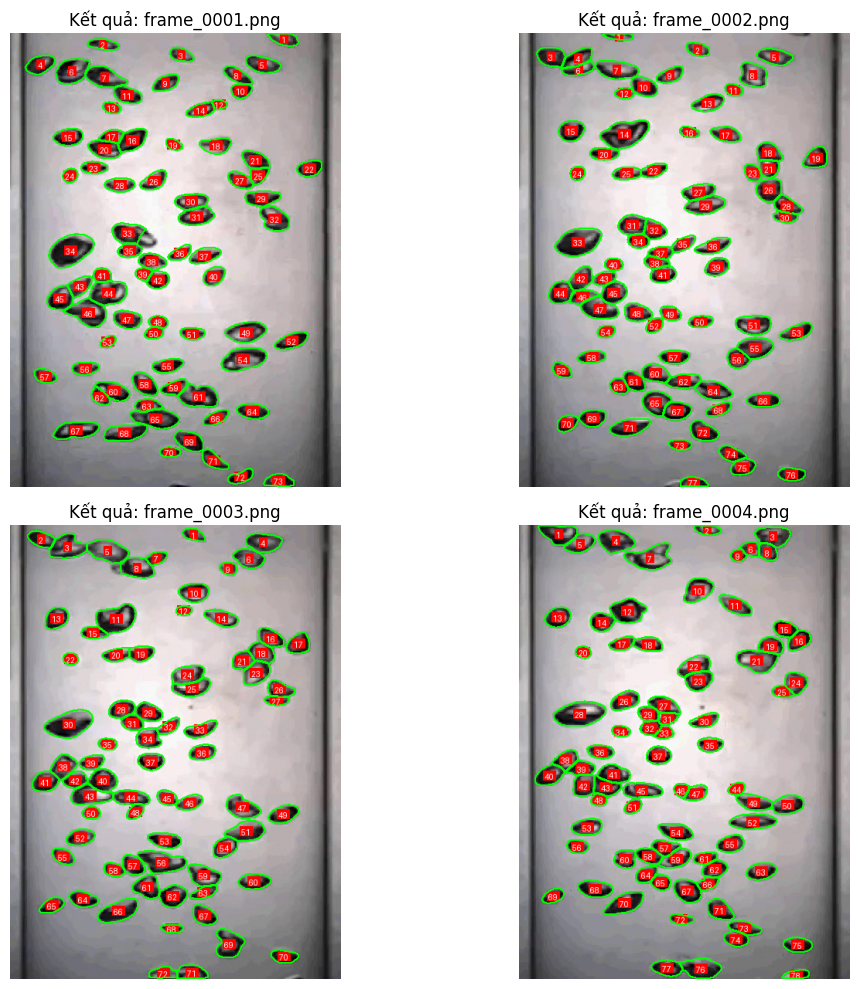

✓ Xem trước kết quả tại: /content/preview_results.png


In [ ]:
# 1. Cài đặt lại Cellpose version mới
!pip install --upgrade cellpose

# 2. Import đúng cách
import cv2
import numpy as np
from cellpose import models
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image, ImageDraw, ImageFont

# 3. Khởi tạo model - CÁCH MỚI
print("Khởi tạo Cellpose model...")
try:
    # Cách 1: Dùng hàm models() - phiên bản mới
    model = models.CellposeModel(gpu=True, model_type='cyto')
except:
    # Cách 2: Nếu vẫn lỗi, thử cách cũ
    model = models.Cellpose(gpu=True, model_type='cyto')

# 4. Đường dẫn tới folder ảnh
image_folder = Path('/content/frames')
output_folder = Path('/content/labeled_bubbles')
output_folder.mkdir(exist_ok=True)

# 5. Hàm xử lý ảnh
def detect_and_label_bubbles(image_path, model, output_path):
    # Đọc ảnh
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Không thể đọc ảnh: {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Chạy Cellpose - CÁCH MỚI
    print(f"Phát hiện bubble trong {image_path.name}...")
    masks, flows, styles = model.eval(
        img_rgb,
        diameter=30,
        channels=[0, 0]  # [0,0] = grayscale
    )

    # Tạo ảnh output
    img_labeled = img_rgb.copy()
    img_pil = Image.fromarray(img_labeled)
    draw = ImageDraw.Draw(img_pil)

    # Đánh nhãn từng bubble
    label_count = 0
    for mask_id in np.unique(masks):
        if mask_id == 0:  # Bỏ qua background
            continue

        label_count += 1

        # Tìm vị trí trung tâm của bubble
        points = np.where(masks == mask_id)
        center_y = int(np.mean(points[0]))
        center_x = int(np.mean(points[1]))

        # Vẽ số nhãn
        text = str(label_count)
        text_bbox = draw.textbbox((center_x, center_y), text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Vẽ hình chữ nhật nền cho text
        padding = 2
        draw.rectangle(
            [center_x - text_width//2 - padding,
             center_y - text_height//2 - padding,
             center_x + text_width//2 + padding,
             center_y + text_height//2 + padding],
            fill=(255, 0, 0)
        )

        # Vẽ text
        draw.text((center_x - text_width//2, center_y - text_height//2),
                 text, fill=(255, 255, 255))

        # Vẽ contour của bubble
        contours = measure.find_contours(masks == mask_id, 0.5)
        for contour in contours:
            contour_points = [(int(pt[1]), int(pt[0])) for pt in contour]
            if len(contour_points) > 2:
                draw.polygon(contour_points, outline=(0, 255, 0), width=2)

    # Lưu ảnh đã đánh nhãn
    img_pil.save(output_path)
    print(f"✓ Tìm thấy {label_count} bubble - Lưu vào: {output_path}")

    return label_count

# 6. Xử lý tất cả ảnh trong folder
print("=" * 50)
print("BẮT ĐẦU PHÁT HIỆN VÀ ĐÁNH NHÃ BUBBLE")
print("=" * 50)

image_files = sorted(list(image_folder.glob('*.jpg')) +
                     list(image_folder.glob('*.png')) +
                     list(image_folder.glob('*.jpeg')))

print(f"Tìm thấy {len(image_files)} ảnh")

total_bubbles = 0
for image_path in image_files:
    output_path = output_folder / f"labeled_{image_path.name}"
    num_bubbles = detect_and_label_bubbles(image_path, model, output_path)
    if num_bubbles:
        total_bubbles += num_bubbles

print("=" * 50)
print(f"✓ HOÀN THÀNH! Tổng số bubble: {total_bubbles}")
print(f"✓ Ảnh đã lưu trong: {output_folder}")
print("=" * 50)

# 7. Hiển thị một vài ảnh kết quả
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, image_path in enumerate(image_files[:4]):
    output_path = output_folder / f"labeled_{image_path.name}"
    if output_path.exists():
        img = Image.open(output_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"Kết quả: {image_path.name}")
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('/content/preview_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Xem trước kết quả tại: /content/preview_results.png")


In [ ]:
from google.colab import drive
import shutil
from pathlib import Path

print("=" * 60)
print("COPY FOLDER SANG GOOGLE DRIVE")
print("=" * 60)


# Đường dẫn nguồn và đích
source_folder = Path('/content/labeled_bubbles')
drive_output_folder = Path('/content/drive/MyDrive/IoT/Lam_bubbles')

print(f"\nNguồn: {source_folder}")
print(f"Đích: {drive_output_folder}\n")

# Kiểm tra folder nguồn có tồn tại không
if not source_folder.exists():
    print(f"✗ Lỗi: Folder {source_folder} không tồn tại!")
else:
    print(f"✓ Tìm thấy folder: {source_folder}")

    try:
        # Tạo thư mục đích nếu chưa có
        drive_output_folder.mkdir(parents=True, exist_ok=True)

        # Nếu folder đích đã có nội dung, xóa nó
        if any(drive_output_folder.iterdir()):
            print("Xóa nội dung cũ...")
            shutil.rmtree(drive_output_folder)
            drive_output_folder.mkdir(parents=True, exist_ok=True)

        # Copy toàn bộ folder
        print("Copying...")
        shutil.copytree(source_folder, drive_output_folder, dirs_exist_ok=True)

        print(f"\n✓ Copy thành công!")
        print(f"✓ Dataset được lưu tại: {drive_output_folder}")

        # Kiểm tra số file
        total_files = sum([len(files) for r, d, files in __import__('os').walk(drive_output_folder)])
        print(f"✓ Tổng files: {total_files}")

        # Hiển thị cấu trúc
        print(f"\nCấu trúc thư mục:")
        print(f"{drive_output_folder}/")
        for item in sorted(drive_output_folder.iterdir())[:10]:
            print(f"  ├─ {item.name}")

    except Exception as e:
        print(f"✗ Lỗi: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "=" * 60)
print("✓ HOÀN THÀNH!")
print("=" * 60)


COPY FOLDER SANG GOOGLE DRIVE

Nguồn: /content/labeled_bubbles
Đích: /content/drive/MyDrive/IoT/Lam_bubbles

✓ Tìm thấy folder: /content/labeled_bubbles
Copying...

✓ Copy thành công!
✓ Dataset được lưu tại: /content/drive/MyDrive/IoT/Lam_bubbles
✓ Tổng files: 886

Cấu trúc thư mục:
/content/drive/MyDrive/IoT/Lam_bubbles/
  ├─ labeled_frame_0001.png
  ├─ labeled_frame_0002.png
  ├─ labeled_frame_0003.png
  ├─ labeled_frame_0004.png
  ├─ labeled_frame_0005.png
  ├─ labeled_frame_0006.png
  ├─ labeled_frame_0007.png
  ├─ labeled_frame_0008.png
  ├─ labeled_frame_0009.png
  ├─ labeled_frame_0010.png

✓ HOÀN THÀNH!


In [ ]:
# 1. Cài đặt
# !pip install --upgrade cellpose opencv-python scikit-image numpy pillow matplotlib

# 2. Import
import cv2
import numpy as np
from cellpose import models
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 3. Khởi tạo Cellpose model
print("Khởi tạo Cellpose model...")
model = models.CellposeModel(gpu=True, model_type='cyto')

# 4. Đường dẫn
image_folder = Path('/content/frames')
output_folder = Path('/content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc')
output_folder.mkdir(exist_ok=True)

# 5. Hàm tạo mask riêng cho mỗi bubble
def extract_individual_masks(image_path, model, output_folder):
    """
    Detect bubbles và tạo 1 mask riêng cho mỗi bubble
    """
    # Đọc ảnh
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Không thể đọc ảnh: {image_path}")
        return 0

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # Chạy Cellpose
    print(f"Phát hiện bubble trong {image_path.name}...")
    masks, flows, styles = model.eval(img_rgb, diameter=30, channels=[0, 0])

    # Tạo folder riêng cho ảnh này
    img_output_folder = output_folder / image_path.stem
    img_output_folder.mkdir(exist_ok=True)

    # Lưu mask gốc
    original_mask_path = img_output_folder / "original_mask.png"
    cv2.imwrite(str(original_mask_path), masks.astype(np.uint8))

    # Lấy danh sách bubble (bỏ background = 0)
    bubble_ids = np.unique(masks)
    bubble_ids = bubble_ids[bubble_ids != 0]

    label_count = 0

    # Tạo mask riêng cho mỗi bubble
    for bubble_id in bubble_ids:
        label_count += 1

        # Tạo mask chỉ chứa bubble này
        individual_mask = np.zeros((h, w), dtype=np.uint8)
        individual_mask[masks == bubble_id] = 255

        # Lưu mask
        mask_path = img_output_folder / f"bubble_{label_count:04d}.png"
        cv2.imwrite(str(mask_path), individual_mask)

        # Lưu ảnh gốc đã crop (tùy chọn)
        points = np.where(masks == bubble_id)
        y_min, y_max = points[0].min(), points[0].max()
        x_min, x_max = points[1].min(), points[1].max()

        # Thêm padding
        padding = 10
        y_min = max(0, y_min - padding)
        y_max = min(h, y_max + padding)
        x_min = max(0, x_min - padding)
        x_max = min(w, x_max + padding)

        # Crop ảnh
        # cropped_img = img_rgb[y_min:y_max, x_min:x_max]
        # cropped_mask = individual_mask[y_min:y_max, x_min:x_max]

        # # Lưu ảnh crop
        # crop_path = img_output_folder / f"bubble_{label_count:04d}_crop.png"
        # cv2.imwrite(str(crop_path), cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))

        # # Lưu ảnh với mask overlay
        # overlay_path = img_output_folder / f"bubble_{label_count:04d}_overlay.png"
        # overlay_img = cropped_img.copy()
        # overlay_img[cropped_mask == 255] = [0, 255, 0]  # Xanh lá
        # cv2.imwrite(str(overlay_path), cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR))

    print(f"✓ Tìm thấy {label_count} bubble")
    print(f"✓ Lưu vào: {img_output_folder}")
    print(f"  - Mỗi bubble có 3 file: mask, crop, overlay")

    return label_count

# 6. Xử lý tất cả ảnh
print("=" * 60)
print("BẮT ĐẦU TÁCH BUBBLE - MỖI BUBBLE 1 MASK RIÊNG")
print("=" * 60)

image_files = sorted(list(image_folder.glob('*.jpg')) +
                     list(image_folder.glob('*.png')) +
                     list(image_folder.glob('*.jpeg')))

print(f"Tìm thấy {len(image_files)} ảnh\n")

total_bubbles = 0
for image_path in image_files:
    num_bubbles = extract_individual_masks(image_path, model, output_folder)
    total_bubbles += num_bubbles
    print()

print("=" * 60)
print(f"✓ HOÀN THÀNH!")
print(f"✓ Tổng số bubble: {total_bubbles}")
print(f"✓ Kết quả lưu tại: {output_folder}")
print("=" * 60)

# 7. Tóm tắt cấu trúc thư mục
print("\nCấu trúc thư mục kết quả:")
print(f"{output_folder}/")
for img_folder in sorted(output_folder.iterdir()):
    if img_folder.is_dir():
        print(f"  └─ {img_folder.name}/")
        for file in sorted(img_folder.iterdir())[:5]:  # Hiển thị 5 file đầu
            print(f"     ├─ {file.name}")
        if len(list(img_folder.iterdir())) > 5:
            print(f"     └─ ... ({len(list(img_folder.iterdir()))} files total)")




Khởi tạo Cellpose model...


100%|██████████| 1.15G/1.15G [00:07<00:00, 161MB/s]


BẮT ĐẦU TÁCH BUBBLE - MỖI BUBBLE 1 MASK RIÊNG
Tìm thấy 886 ảnh

Phát hiện bubble trong frame_0001.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0001
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0002.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0002
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0003.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0003
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0004.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0004
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0005.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0005
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0006.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0006
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0007.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0007
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0008.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0008
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0009.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0009
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0010.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0010
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0011.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0011
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0012.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0012
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0013.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0013
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0014.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0014
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0015.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0015
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0016.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0016
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0017.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0017
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0018.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0018
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0019.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0019
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0020.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0020
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0021.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0021
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0022.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0022
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0023.png...


✓ Tìm thấy 101 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0023
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0024.png...


✓ Tìm thấy 101 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0024
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0025.png...


✓ Tìm thấy 102 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0025
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0026.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0026
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0027.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0027
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0028.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0028
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0029.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0029
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0030.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0030
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0031.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0031
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0032.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0032
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0033.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0033
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0034.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0034
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0035.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0035
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0036.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0036
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0037.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0037
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0038.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0038
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0039.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0039
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0040.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0040
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0041.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0041
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0042.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0042
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0043.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0043
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0044.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0044
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0045.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0045
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0046.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0046
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0047.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0047
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0048.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0048
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0049.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0049
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0050.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0050
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0051.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0051
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0052.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0052
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0053.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0053
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0054.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0054
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0055.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0055
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0056.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0056
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0057.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0057
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0058.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0058
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0059.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0059
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0060.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0060
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0061.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0061
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0062.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0062
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0063.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0063
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0064.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0064
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0065.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0065
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0066.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0066
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0067.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0067
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0068.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0068
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0069.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0069
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0070.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0070
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0071.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0071
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0072.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0072
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0073.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0073
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0074.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0074
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0075.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0075
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0076.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0076
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0077.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0077
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0078.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0078
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0079.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0079
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0080.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0080
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0081.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0081
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0082.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0082
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0083.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0083
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0084.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0084
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0085.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0085
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0086.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0086
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0087.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0087
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0088.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0088
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0089.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0089
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0090.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0090
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0091.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0091
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0092.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0092
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0093.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0093
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0094.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0094
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0095.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0095
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0096.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0096
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0097.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0097
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0098.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0098
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0099.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0099
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0100.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0100
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0101.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0101
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0102.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0102
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0103.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0103
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0104.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0104
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0105.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0105
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0106.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0106
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0107.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0107
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0108.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0108
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0109.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0109
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0110.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0110
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0111.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0111
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0112.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0112
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0113.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0113
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0114.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0114
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0115.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0115
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0116.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0116
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0117.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0117
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0118.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0118
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0119.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0119
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0120.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0120
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0121.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0121
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0122.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0122
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0123.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0123
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0124.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0124
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0125.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0125
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0126.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0126
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0127.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0127
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0128.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0128
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0129.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0129
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0130.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0130
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0131.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0131
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0132.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0132
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0133.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0133
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0134.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0134
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0135.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0135
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0136.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0136
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0137.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0137
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0138.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0138
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0139.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0139
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0140.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0140
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0141.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0141
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0142.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0142
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0143.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0143
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0144.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0144
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0145.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0145
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0146.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0146
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0147.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0147
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0148.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0148
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0149.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0149
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0150.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0150
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0151.png...


✓ Tìm thấy 100 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0151
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0152.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0152
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0153.png...


✓ Tìm thấy 103 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0153
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0154.png...


✓ Tìm thấy 101 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0154
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0155.png...


✓ Tìm thấy 105 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0155
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0156.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0156
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0157.png...


✓ Tìm thấy 106 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0157
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0158.png...


✓ Tìm thấy 107 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0158
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0159.png...


✓ Tìm thấy 102 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0159
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0160.png...


✓ Tìm thấy 103 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0160
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0161.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0161
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0162.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0162
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0163.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0163
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0164.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0164
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0165.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0165
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0166.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0166
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0167.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0167
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0168.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0168
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0169.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0169
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0170.png...


✓ Tìm thấy 100 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0170
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0171.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0171
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0172.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0172
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0173.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0173
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0174.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0174
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0175.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0175
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0176.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0176
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0177.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0177
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0178.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0178
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0179.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0179
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0180.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0180
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0181.png...


✓ Tìm thấy 101 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0181
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0182.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0182
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0183.png...


✓ Tìm thấy 101 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0183
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0184.png...


✓ Tìm thấy 104 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0184
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0185.png...


✓ Tìm thấy 105 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0185
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0186.png...


✓ Tìm thấy 101 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0186
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0187.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0187
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0188.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0188
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0189.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0189
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0190.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0190
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0191.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0191
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0192.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0192
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0193.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0193
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0194.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0194
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0195.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0195
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0196.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0196
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0197.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0197
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0198.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0198
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0199.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0199
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0200.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0200
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0201.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0201
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0202.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0202
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0203.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0203
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0204.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0204
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0205.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0205
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0206.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0206
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0207.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0207
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0208.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0208
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0209.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0209
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0210.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0210
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0211.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0211
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0212.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0212
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0213.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0213
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0214.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0214
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0215.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0215
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0216.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0216
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0217.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0217
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0218.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0218
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0219.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0219
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0220.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0220
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0221.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0221
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0222.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0222
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0223.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0223
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0224.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0224
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0225.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0225
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0226.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0226
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0227.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0227
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0228.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0228
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0229.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0229
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0230.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0230
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0231.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0231
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0232.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0232
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0233.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0233
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0234.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0234
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0235.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0235
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0236.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0236
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0237.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0237
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0238.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0238
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0239.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0239
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0240.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0240
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0241.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0241
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0242.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0242
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0243.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0243
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0244.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0244
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0245.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0245
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0246.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0246
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0247.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0247
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0248.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0248
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0249.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0249
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0250.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0250
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0251.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0251
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0252.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0252
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0253.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0253
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0254.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0254
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0255.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0255
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0256.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0256
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0257.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0257
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0258.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0258
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0259.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0259
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0260.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0260
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0261.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0261
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0262.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0262
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0263.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0263
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0264.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0264
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0265.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0265
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0266.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0266
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0267.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0267
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0268.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0268
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0269.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0269
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0270.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0270
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0271.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0271
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0272.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0272
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0273.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0273
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0274.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0274
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0275.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0275
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0276.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0276
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0277.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0277
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0278.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0278
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0279.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0279
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0280.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0280
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0281.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0281
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0282.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0282
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0283.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0283
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0284.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0284
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0285.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0285
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0286.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0286
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0287.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0287
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0288.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0288
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0289.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0289
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0290.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0290
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0291.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0291
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0292.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0292
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0293.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0293
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0294.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0294
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0295.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0295
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0296.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0296
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0297.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0297
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0298.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0298
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0299.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0299
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0300.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0300
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0301.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0301
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0302.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0302
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0303.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0303
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0304.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0304
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0305.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0305
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0306.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0306
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0307.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0307
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0308.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0308
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0309.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0309
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0310.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0310
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0311.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0311
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0312.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0312
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0313.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0313
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0314.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0314
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0315.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0315
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0316.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0316
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0317.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0317
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0318.png...


✓ Tìm thấy 69 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0318
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0319.png...


✓ Tìm thấy 68 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0319
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0320.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0320
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0321.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0321
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0322.png...


✓ Tìm thấy 64 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0322
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0323.png...


✓ Tìm thấy 65 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0323
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0324.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0324
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0325.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0325
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0326.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0326
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0327.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0327
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0328.png...


✓ Tìm thấy 68 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0328
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0329.png...


✓ Tìm thấy 69 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0329
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0330.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0330
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0331.png...


✓ Tìm thấy 66 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0331
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0332.png...


✓ Tìm thấy 65 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0332
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0333.png...


✓ Tìm thấy 65 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0333
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0334.png...


✓ Tìm thấy 65 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0334
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0335.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0335
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0336.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0336
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0337.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0337
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0338.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0338
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0339.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0339
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0340.png...


✓ Tìm thấy 67 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0340
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0341.png...


✓ Tìm thấy 64 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0341
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0342.png...


✓ Tìm thấy 65 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0342
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0343.png...


✓ Tìm thấy 62 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0343
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0344.png...


✓ Tìm thấy 68 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0344
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0345.png...


✓ Tìm thấy 65 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0345
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0346.png...


✓ Tìm thấy 66 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0346
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0347.png...


✓ Tìm thấy 64 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0347
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0348.png...


✓ Tìm thấy 69 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0348
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0349.png...


✓ Tìm thấy 68 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0349
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0350.png...


✓ Tìm thấy 69 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0350
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0351.png...


✓ Tìm thấy 69 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0351
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0352.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0352
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0353.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0353
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0354.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0354
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0355.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0355
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0356.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0356
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0357.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0357
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0358.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0358
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0359.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0359
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0360.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0360
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0361.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0361
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0362.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0362
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0363.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0363
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0364.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0364
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0365.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0365
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0366.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0366
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0367.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0367
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0368.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0368
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0369.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0369
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0370.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0370
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0371.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0371
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0372.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0372
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0373.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0373
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0374.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0374
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0375.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0375
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0376.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0376
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0377.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0377
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0378.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0378
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0379.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0379
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0380.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0380
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0381.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0381
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0382.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0382
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0383.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0383
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0384.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0384
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0385.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0385
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0386.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0386
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0387.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0387
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0388.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0388
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0389.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0389
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0390.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0390
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0391.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0391
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0392.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0392
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0393.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0393
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0394.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0394
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0395.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0395
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0396.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0396
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0397.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0397
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0398.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0398
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0399.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0399
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0400.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0400
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0401.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0401
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0402.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0402
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0403.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0403
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0404.png...


✓ Tìm thấy 100 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0404
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0405.png...


✓ Tìm thấy 102 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0405
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0406.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0406
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0407.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0407
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0408.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0408
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0409.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0409
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0410.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0410
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0411.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0411
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0412.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0412
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0413.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0413
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0414.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0414
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0415.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0415
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0416.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0416
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0417.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0417
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0418.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0418
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0419.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0419
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0420.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0420
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0421.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0421
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0422.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0422
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0423.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0423
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0424.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0424
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0425.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0425
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0426.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0426
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0427.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0427
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0428.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0428
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0429.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0429
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0430.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0430
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0431.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0431
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0432.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0432
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0433.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0433
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0434.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0434
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0435.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0435
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0436.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0436
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0437.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0437
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0438.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0438
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0439.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0439
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0440.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0440
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0441.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0441
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0442.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0442
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0443.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0443
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0444.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0444
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0445.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0445
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0446.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0446
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0447.png...


✓ Tìm thấy 68 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0447
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0448.png...


✓ Tìm thấy 67 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0448
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0449.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0449
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0450.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0450
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0451.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0451
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0452.png...


✓ Tìm thấy 65 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0452
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0453.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0453
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0454.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0454
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0455.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0455
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0456.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0456
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0457.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0457
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0458.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0458
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0459.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0459
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0460.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0460
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0461.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0461
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0462.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0462
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0463.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0463
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0464.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0464
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0465.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0465
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0466.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0466
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0467.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0467
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0468.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0468
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0469.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0469
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0470.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0470
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0471.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0471
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0472.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0472
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0473.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0473
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0474.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0474
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0475.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0475
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0476.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0476
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0477.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0477
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0478.png...


✓ Tìm thấy 68 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0478
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0479.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0479
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0480.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0480
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0481.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0481
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0482.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0482
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0483.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0483
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0484.png...


✓ Tìm thấy 68 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0484
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0485.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0485
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0486.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0486
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0487.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0487
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0488.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0488
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0489.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0489
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0490.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0490
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0491.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0491
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0492.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0492
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0493.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0493
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0494.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0494
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0495.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0495
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0496.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0496
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0497.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0497
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0498.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0498
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0499.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0499
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0500.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0500
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0501.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0501
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0502.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0502
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0503.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0503
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0504.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0504
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0505.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0505
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0506.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0506
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0507.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0507
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0508.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0508
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0509.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0509
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0510.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0510
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0511.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0511
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0512.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0512
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0513.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0513
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0514.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0514
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0515.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0515
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0516.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0516
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0517.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0517
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0518.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0518
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0519.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0519
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0520.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0520
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0521.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0521
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0522.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0522
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0523.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0523
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0524.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0524
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0525.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0525
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0526.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0526
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0527.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0527
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0528.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0528
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0529.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0529
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0530.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0530
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0531.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0531
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0532.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0532
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0533.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0533
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0534.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0534
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0535.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0535
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0536.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0536
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0537.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0537
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0538.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0538
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0539.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0539
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0540.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0540
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0541.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0541
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0542.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0542
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0543.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0543
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0544.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0544
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0545.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0545
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0546.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0546
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0547.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0547
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0548.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0548
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0549.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0549
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0550.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0550
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0551.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0551
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0552.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0552
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0553.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0553
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0554.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0554
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0555.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0555
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0556.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0556
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0557.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0557
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0558.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0558
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0559.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0559
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0560.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0560
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0561.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0561
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0562.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0562
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0563.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0563
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0564.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0564
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0565.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0565
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0566.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0566
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0567.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0567
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0568.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0568
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0569.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0569
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0570.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0570
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0571.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0571
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0572.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0572
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0573.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0573
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0574.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0574
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0575.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0575
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0576.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0576
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0577.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0577
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0578.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0578
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0579.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0579
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0580.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0580
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0581.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0581
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0582.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0582
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0583.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0583
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0584.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0584
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0585.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0585
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0586.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0586
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0587.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0587
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0588.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0588
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0589.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0589
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0590.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0590
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0591.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0591
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0592.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0592
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0593.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0593
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0594.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0594
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0595.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0595
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0596.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0596
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0597.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0597
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0598.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0598
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0599.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0599
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0600.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0600
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0601.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0601
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0602.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0602
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0603.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0603
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0604.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0604
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0605.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0605
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0606.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0606
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0607.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0607
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0608.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0608
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0609.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0609
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0610.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0610
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0611.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0611
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0612.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0612
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0613.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0613
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0614.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0614
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0615.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0615
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0616.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0616
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0617.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0617
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0618.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0618
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0619.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0619
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0620.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0620
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0621.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0621
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0622.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0622
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0623.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0623
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0624.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0624
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0625.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0625
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0626.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0626
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0627.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0627
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0628.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0628
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0629.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0629
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0630.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0630
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0631.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0631
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0632.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0632
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0633.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0633
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0634.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0634
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0635.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0635
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0636.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0636
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0637.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0637
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0638.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0638
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0639.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0639
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0640.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0640
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0641.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0641
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0642.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0642
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0643.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0643
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0644.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0644
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0645.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0645
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0646.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0646
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0647.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0647
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0648.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0648
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0649.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0649
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0650.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0650
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0651.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0651
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0652.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0652
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0653.png...


✓ Tìm thấy 100 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0653
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0654.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0654
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0655.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0655
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0656.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0656
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0657.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0657
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0658.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0658
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0659.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0659
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0660.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0660
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0661.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0661
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0662.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0662
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0663.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0663
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0664.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0664
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0665.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0665
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0666.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0666
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0667.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0667
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0668.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0668
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0669.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0669
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0670.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0670
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0671.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0671
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0672.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0672
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0673.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0673
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0674.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0674
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0675.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0675
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0676.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0676
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0677.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0677
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0678.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0678
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0679.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0679
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0680.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0680
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0681.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0681
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0682.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0682
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0683.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0683
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0684.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0684
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0685.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0685
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0686.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0686
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0687.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0687
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0688.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0688
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0689.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0689
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0690.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0690
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0691.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0691
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0692.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0692
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0693.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0693
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0694.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0694
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0695.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0695
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0696.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0696
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0697.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0697
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0698.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0698
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0699.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0699
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0700.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0700
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0701.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0701
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0702.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0702
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0703.png...


✓ Tìm thấy 69 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0703
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0704.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0704
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0705.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0705
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0706.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0706
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0707.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0707
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0708.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0708
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0709.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0709
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0710.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0710
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0711.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0711
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0712.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0712
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0713.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0713
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0714.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0714
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0715.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0715
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0716.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0716
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0717.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0717
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0718.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0718
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0719.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0719
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0720.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0720
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0721.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0721
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0722.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0722
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0723.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0723
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0724.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0724
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0725.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0725
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0726.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0726
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0727.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0727
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0728.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0728
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0729.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0729
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0730.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0730
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0731.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0731
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0732.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0732
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0733.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0733
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0734.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0734
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0735.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0735
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0736.png...


✓ Tìm thấy 94 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0736
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0737.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0737
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0738.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0738
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0739.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0739
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0740.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0740
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0741.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0741
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0742.png...


✓ Tìm thấy 95 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0742
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0743.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0743
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0744.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0744
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0745.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0745
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0746.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0746
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0747.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0747
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0748.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0748
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0749.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0749
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0750.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0750
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0751.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0751
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0752.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0752
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0753.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0753
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0754.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0754
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0755.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0755
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0756.png...


✓ Tìm thấy 100 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0756
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0757.png...


✓ Tìm thấy 93 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0757
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0758.png...


✓ Tìm thấy 104 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0758
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0759.png...


✓ Tìm thấy 92 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0759
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0760.png...


✓ Tìm thấy 100 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0760
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0761.png...


✓ Tìm thấy 102 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0761
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0762.png...


✓ Tìm thấy 105 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0762
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0763.png...


✓ Tìm thấy 110 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0763
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0764.png...


✓ Tìm thấy 108 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0764
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0765.png...


✓ Tìm thấy 104 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0765
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0766.png...


✓ Tìm thấy 105 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0766
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0767.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0767
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0768.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0768
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0769.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0769
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0770.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0770
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0771.png...


✓ Tìm thấy 102 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0771
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0772.png...


✓ Tìm thấy 99 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0772
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0773.png...


✓ Tìm thấy 98 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0773
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0774.png...


✓ Tìm thấy 96 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0774
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0775.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0775
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0776.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0776
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0777.png...


✓ Tìm thấy 103 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0777
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0778.png...


✓ Tìm thấy 104 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0778
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0779.png...


✓ Tìm thấy 104 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0779
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0780.png...


✓ Tìm thấy 97 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0780
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0781.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0781
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0782.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0782
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0783.png...


✓ Tìm thấy 91 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0783
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0784.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0784
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0785.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0785
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0786.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0786
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0787.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0787
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0788.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0788
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0789.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0789
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0790.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0790
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0791.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0791
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0792.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0792
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0793.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0793
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0794.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0794
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0795.png...


✓ Tìm thấy 80 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0795
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0796.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0796
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0797.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0797
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0798.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0798
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0799.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0799
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0800.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0800
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0801.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0801
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0802.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0802
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0803.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0803
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0804.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0804
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0805.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0805
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0806.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0806
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0807.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0807
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0808.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0808
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0809.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0809
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0810.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0810
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0811.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0811
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0812.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0812
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0813.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0813
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0814.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0814
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0815.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0815
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0816.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0816
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0817.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0817
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0818.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0818
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0819.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0819
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0820.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0820
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0821.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0821
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0822.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0822
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0823.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0823
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0824.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0824
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0825.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0825
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0826.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0826
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0827.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0827
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0828.png...


✓ Tìm thấy 71 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0828
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0829.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0829
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0830.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0830
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0831.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0831
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0832.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0832
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0833.png...


✓ Tìm thấy 90 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0833
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0834.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0834
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0835.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0835
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0836.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0836
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0837.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0837
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0838.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0838
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0839.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0839
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0840.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0840
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0841.png...


✓ Tìm thấy 89 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0841
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0842.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0842
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0843.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0843
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0844.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0844
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0845.png...


✓ Tìm thấy 87 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0845
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0846.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0846
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0847.png...


✓ Tìm thấy 88 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0847
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0848.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0848
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0849.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0849
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0850.png...


✓ Tìm thấy 83 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0850
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0851.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0851
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0852.png...


✓ Tìm thấy 77 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0852
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0853.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0853
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0854.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0854
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0855.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0855
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0856.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0856
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0857.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0857
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0858.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0858
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0859.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0859
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0860.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0860
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0861.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0861
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0862.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0862
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0863.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0863
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0864.png...


✓ Tìm thấy 78 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0864
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0865.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0865
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0866.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0866
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0867.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0867
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0868.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0868
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0869.png...


✓ Tìm thấy 81 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0869
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0870.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0870
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0871.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0871
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0872.png...


✓ Tìm thấy 82 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0872
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0873.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0873
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0874.png...


✓ Tìm thấy 85 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0874
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0875.png...


✓ Tìm thấy 86 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0875
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0876.png...


✓ Tìm thấy 84 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0876
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0877.png...


✓ Tìm thấy 79 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0877
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0878.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0878
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0879.png...


✓ Tìm thấy 73 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0879
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0880.png...


✓ Tìm thấy 76 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0880
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0881.png...


✓ Tìm thấy 70 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0881
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0882.png...


✓ Tìm thấy 72 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0882
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0883.png...


✓ Tìm thấy 75 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0883
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0884.png...


✓ Tìm thấy 74 bubble
✓ Lưu vào: /content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc/frame_0884
  - Mỗi bubble có 3 file: mask, crop, overlay

Phát hiện bubble trong frame_0885.png...


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
     ├─ bubble_0005.png
     └─ ... (95 files total)
  └─ frame_0173/
     ├─ bubble_0001.png
     ├─ bubble_0002.png
     ├─ bubble_0003.png
     ├─ bubble_0004.png
     ├─ bubble_0005.png
     └─ ... (99 files total)
  └─ frame_0174/
     ├─ bubble_0001.png
     ├─ bubble_0002.png
     ├─ bubble_0003.png
     ├─ bubble_0004.png
     ├─ bubble_0005.png
     └─ ... (97 files total)
  └─ frame_0175/
     ├─ bubble_0001.png
     ├─ bubble_0002.png
     ├─ bubble_0003.png
     ├─ bubble_0004.png
     ├─ bubble_0005.png
     └─ ... (92 files total)
  └─ frame_0176/
     ├─ bubble_0001.png
     ├─ bubble_0002.png
     ├─ bubble_0003.png
     ├─ bubble_0004.png
     ├─ bubble_0005.png
     └─ ... (99 files total)
  └─ frame_0177/
     ├─ bubble_0001.png
     ├─ bubble_0002.png
     ├─ bubble_0003.png
     ├─ bubble_0004.png
     ├─ bubble_0005.png
     └─ ... (94 files total)
  └─ frame_0178/
     ├─ bubble_0001.png
     ├─ bubble_0002

In [ ]:
# 1. Cài đặt
# !pip install --upgrade cellpose opencv-python scikit-image numpy pillow matplotlib

# 2. Import
import cv2
import numpy as np
from cellpose import models
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 3. Khởi tạo Cellpose model
print("Khởi tạo Cellpose model...")
model = models.CellposeModel(gpu=True, model_type='cyto')

# 4. Đường dẫn
image_folder = Path('/content/frames')
output_folder = Path('/content/drive/MyDrive/IoT/standard_data_Lam_dinhvcc')
output_folder.mkdir(exist_ok=True)

# 5. Hàm tạo mask riêng cho mỗi bubble
def extract_individual_masks(image_path, model, output_folder):
    """
    Detect bubbles và tạo 1 mask riêng cho mỗi bubble
    """
    # Đọc ảnh
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"Không thể đọc ảnh: {image_path}")
        return 0

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # Chạy Cellpose
    print(f"Phát hiện bubble trong {image_path.name}...")
    masks, flows, styles = model.eval(img_rgb, diameter=30, channels=[0, 0])

    # Tạo folder riêng cho ảnh này
    img_output_folder = output_folder / image_path.stem
    img_output_folder.mkdir(exist_ok=True)

    # Lưu mask gốc
    original_mask_path = img_output_folder / "original_mask.png"
    cv2.imwrite(str(original_mask_path), masks.astype(np.uint8))

    # Lấy danh sách bubble (bỏ background = 0)
    bubble_ids = np.unique(masks)
    bubble_ids = bubble_ids[bubble_ids != 0]

    label_count = 0

    # Tạo mask riêng cho mỗi bubble
    for bubble_id in bubble_ids:
        label_count += 1

        # Tạo mask chỉ chứa bubble này
        individual_mask = np.zeros((h, w), dtype=np.uint8)
        individual_mask[masks == bubble_id] = 255

        # Lưu mask
        mask_path = img_output_folder / f"bubble_{label_count:04d}.png"
        cv2.imwrite(str(mask_path), individual_mask)

        # Lưu ảnh gốc đã crop (tùy chọn)
        points = np.where(masks == bubble_id)
        y_min, y_max = points[0].min(), points[0].max()
        x_min, x_max = points[1].min(), points[1].max()

        # Thêm padding
        padding = 10
        y_min = max(0, y_min - padding)
        y_max = min(h, y_max + padding)
        x_min = max(0, x_min - padding)
        x_max = min(w, x_max + padding)

    print(f"✓ Tìm thấy {label_count} bubble")
    print(f"✓ Lưu vào: {img_output_folder}")
    print(f"  - Mỗi bubble có 3 file: mask, crop, overlay")

    return label_count

# 6. Hàm trích xuất số thứ tự từ tên file
def extract_frame_number(filename):
    """
    Trích xuất số frame từ tên file (ví dụ: frame_0524.jpg -> 524)
    """
    import re
    match = re.search(r'(\d+)', filename.stem)
    if match:
        return int(match.group(1))
    return 0

# 7. Xử lý tất cả ảnh từ 524 trở đi
print("=" * 60)
print("BẮT ĐẦU TÁCH BUBBLE - MỖI BUBBLE 1 MASK RIÊNG")
print("CHỈ XỬ LÝ ẢNH TỪ 524 TRỞ ĐI")
print("=" * 60)

# Lấy tất cả ảnh
all_image_files = sorted(list(image_folder.glob('*.jpg')) +
                         list(image_folder.glob('*.png')) +
                         list(image_folder.glob('*.jpeg')))

# Lọc ảnh từ 524 trở đi
image_files = [img for img in all_image_files if extract_frame_number(img) >= 524]

print(f"Tổng số ảnh trong folder: {len(all_image_files)}")
print(f"Số ảnh sẽ xử lý (từ 524 trở đi): {len(image_files)}\n")

if len(image_files) == 0:
    print("⚠️ KHÔNG TÌM THẤY ẢNH NÀO TỪ 524 TRỞ ĐI!")
else:
    print(f"Ảnh đầu tiên: {image_files[0].name}")
    print(f"Ảnh cuối cùng: {image_files[-1].name}\n")

total_bubbles = 0
for idx, image_path in enumerate(image_files, 1):
    print(f"[{idx}/{len(image_files)}] Đang xử lý: {image_path.name}")
    num_bubbles = extract_individual_masks(image_path, model, output_folder)
    total_bubbles += num_bubbles
    print()

print("=" * 60)
print(f"✓ HOÀN THÀNH!")
print(f"✓ Đã xử lý: {len(image_files)} ảnh")
print(f"✓ Tổng số bubble: {total_bubbles}")
print(f"✓ Kết quả lưu tại: {output_folder}")
print("=" * 60)

# 8. Tóm tắt cấu trúc thư mục
print("\nCấu trúc thư mục kết quả:")
print(f"{output_folder}/")
for img_folder in sorted(output_folder.iterdir()):
    if img_folder.is_dir():
        print(f"  └─ {img_folder.name}/")
        for file in sorted(img_folder.iterdir())[:5]:  # Hiển thị 5 file đầu
            print(f"     ├─ {file.name}")
        if len(list(img_folder.iterdir())) > 5:
            print(f"     └─ ... ({len(list(img_folder.iterdir()))} files total)")


ModuleNotFoundError: No module named 'cellpose'